# Scenario analysis

## Set up environment

In [1]:
# Constants used throughout the file
BASELINE = "BASELINE"
SCN_BASE = "SCN_BASE"
SCN_MIN_LEY = "SCN_MIN_LEY"
SCN_REDUCED_MILK = "SCN_REDUCED_MILK"
SCN_SNG = "SCN_SNG"

PROTEIN_CONTENTS = {
    "Peas (add)": 220,
    "Wheat (add)": 67.15,
    "meat": 155.5,
    "milk": 35.0,
}

In [2]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

from CIBUSmod.utils.misc import inv_dict, aggregate_data_coords_pair
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint
from itertools import product

In [3]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = "data",
    data_path_default = CM_BASEPATH + "/data/default",
)
session

## Land use

### Was all land used?

In [4]:
max_lu = session.get_attr('r', 'max_land_use').droplevel("year")
scn_lu = session.get_attr('c', 'area', { "region": None, "crop": "land_use" }).droplevel("year")
share_lu = (scn_lu / max_lu).replace({np.inf: 1, np.nan: 1})

In [5]:
with pd.option_context('display.max_columns', None):
    display(share_lu)

region               1011                                         111  \
land_use         cropland greenhouse semi-natural grasslands cropland   
scn                                                                     
BASELINE              1.0        1.0                1.000000      1.0   
SCN_BASE              1.0        1.0                0.016836      1.0   
SCN_MIN_LEY           1.0        1.0                1.000000      1.0   
SCN_REDUCED_MILK      1.0        1.0                0.017931      1.0   
SCN_SNG               1.0        1.0                0.965484      1.0   
SCN_ORG               1.0        1.0                0.019415      1.0   

region                                                  1111             \
land_use         greenhouse semi-natural grasslands cropland greenhouse   
scn                                                                       
BASELINE                1.0                1.000000      1.0        1.0   
SCN_BASE                1.0                0.055854      1.0        1.0   
SCN_MIN_LEY             1.0                1.000000      1.0        1.0   
SCN_REDUCED_MILK        1.0                0.055854      1.0        1.0   
SCN_SNG                 1.0                0.952448      1.0        1.0   
SCN_ORG                 1.0                0.042989      1.0        1.0   

region                                       1112             \
land_use         semi-natural grasslands cropland greenhouse   
scn                                                            
BASELINE                        1.000000      1.0        1.0   
SCN_BASE                        0.323418      1.0        1.0   
SCN_MIN_LEY                     1.000000      1.0        1.0   
SCN_REDUCED_MILK                0.465791      1.0        1.0   
SCN_SNG                         0.984986      1.0        1.0   
SCN_ORG                         0.443750      1.0        1.0   

region                                        112             \
land_use         semi-natural grasslands cropland greenhouse   
scn                                                            
BASELINE                             1.0      1.0        1.0   
SCN_BASE                             1.0      1.0        1.0   
SCN_MIN_LEY                          1.0      1.0        1.0   
SCN_REDUCED_MILK                     1.0      1.0        1.0   
SCN_SNG                              1.0      1.0        1.0   
SCN_ORG                              1.0      1.0        1.0   

region                                        1121             \
land_use         semi-natural grasslands  cropland greenhouse   
scn                                                             
BASELINE                        1.000000  0.995693        1.0   
SCN_BASE                        0.032760  1.000000        1.0   
SCN_MIN_LEY                     1.000000  1.000000        1.0   
SCN_REDUCED_MILK                0.034676  1.000000        1.0   
SCN_SNG                         0.927243  1.000000        1.0   
SCN_ORG                         0.027684  1.000000        1.0   

region                                        1122             \
land_use         semi-natural grasslands  cropland greenhouse   
scn                                                             
BASELINE                        1.000000  0.999686        1.0   
SCN_BASE                        0.276915  1.000000        1.0   
SCN_MIN_LEY                     1.000000  1.000000        1.0   
SCN_REDUCED_MILK                0.276915  1.000000        1.0   
SCN_SNG                         0.984188  1.000000        1.0   
SCN_ORG                         0.233440  1.000000        1.0   

region                                        1123             \
land_use         semi-natural grasslands  cropland greenhouse   
scn                                                             
BASELINE                        1.000000  0.998732        1.0   
SCN_BASE                        0.206457  1.000000        1.0   
SCN_MIN_LEY    

### Cropland use

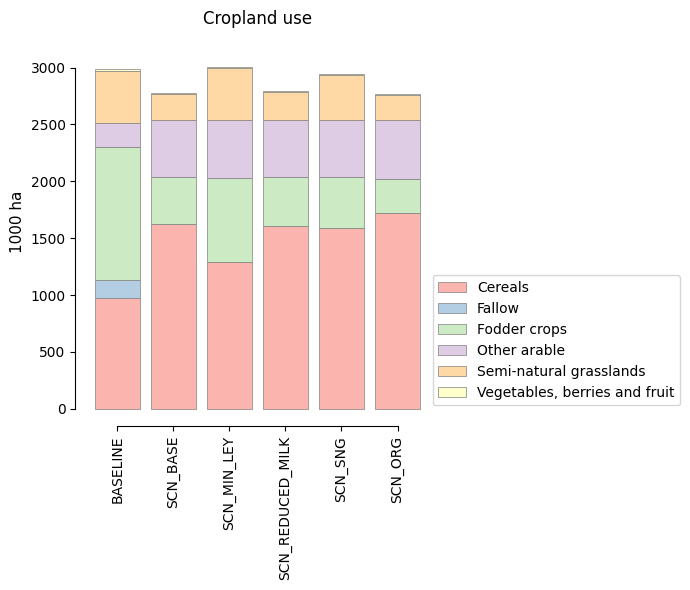

In [6]:
fig, ax = plt.subplots(figsize=(7,6))

factor = 1000
cropland_data = (
    (session.get_attr('C','area',groupby={'crop':'crop_group2'})/factor)
    .drop(['Greenhouse crops'], axis=1)
    .droplevel('year')
)
plot.bar(
    data=cropland_data,
    ax=ax,
    cmap='Pastel1',
    edgecolor='grey'
)

ax.set_title('Cropland use')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel(f'{factor} ha')
ax.set_ylim(top=cropland_data.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

## Distribution of Semi-natural grasslands

crop              Semi-natural meadows  Semi-natural pastures  \
scn                                                             
BASELINE                  11992.051495          370037.380780   
SCN_BASE                  11997.131996          176544.899562   
SCN_MIN_LEY               11945.428420          443971.761580   
SCN_REDUCED_MILK          11997.132000          197117.498112   
SCN_SNG                   11997.132000          375978.136192   
SCN_ORG                   10780.048930          170680.975262   

crop              Semi-natural pastures, thin soils  \
scn                                                   
BASELINE                               60107.313899   
SCN_BASE                               29745.377966   
SCN_MIN_LEY                                0.000000   
SCN_REDUCED_MILK                       29669.260233   
SCN_SNG                                 2214.827757   
SCN_ORG                                33611.031157   

crop              Semi-natural pastures, wooded  
scn                                              
BASELINE                           13632.225618  
SCN_BASE                            4675.057990  
SCN_MIN_LEY                            0.000000  
SCN_REDUCED_MILK                    3879.559863  
SCN_SNG                              534.764183  
SCN_ORG                             2494.027145

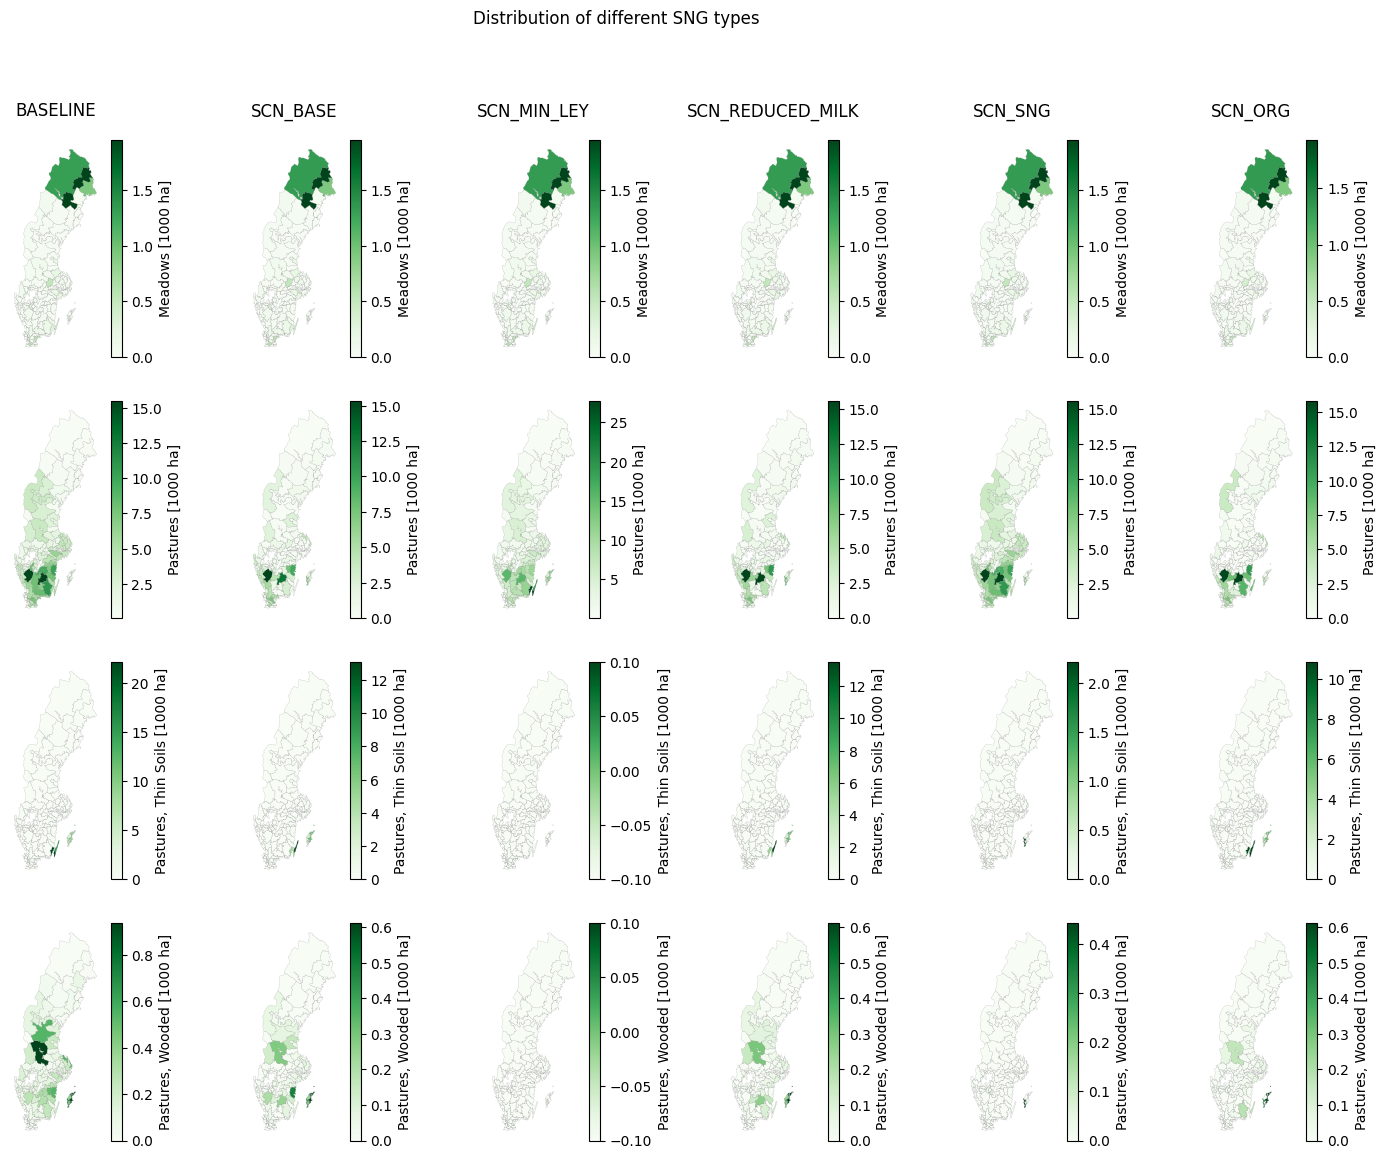

In [7]:
sng_lu = session.get_attr("C","area",{"region": None, "crop": [None, "land_use"]}).droplevel("year").T.xs("semi-natural grasslands", level="land_use").T
sng_types = sng_lu.columns.unique("crop")
scenarios = [scn for scn in session.scenarios()]
n_scn = len(scenarios)

fig, axs2d = plt.subplots(len(sng_types), n_scn, figsize=(n_scn * 3, 3.25*len(sng_types)))
for scn, axs in zip(scenarios, axs2d.T):
    axs[0].set_title(scn)
    for ax, sng_type in zip(axs, sng_types):
        data = sng_lu.loc[scn,(slice(None), sng_type)] / 1e3
        ax.set_axis_off()
        sng_short = sng_type.removeprefix("Semi-natural ").title()
        plot.map_from_series(
            data, ax=ax, 
            edgecolor="grey",
            cmap='Greens', legend_kwds={"label": f"{sng_short} [1000 ha]"},
        )
    fig.suptitle("Distribution of different SNG types")

session.get_attr("C","area",{"crop": [None, "land_use"]}).droplevel("year").T.xs("semi-natural grasslands", level="land_use").T

In [8]:
from IPython.display import display, Markdown
x0_sng = session.get_attr("r", "x0_crops", { "crop": [None, "land_use"] }).T.xs("semi-natural grasslands", level="land_use").T.droplevel("year")
x_sng =  session.get_attr("f", "x_crops",  { "crop": [None, "land_use"] }).T.xs("semi-natural grasslands", level="land_use").T.droplevel("year")

display(Markdown("<h3><strong>How much less of each SNG-type is in the scenario?</strong></h3>"))
x0_sng - x_sng


<h3><strong>How much less of each SNG-type is in the scenario?</strong></h3>

crop              Semi-natural meadows  Semi-natural pastures  \
scn                                                             
BASELINE                  5.080505e+00             118.965292   
SCN_BASE                  3.951862e-06          193611.446510   
SCN_MIN_LEY               5.170358e+01          -73815.415508   
SCN_REDUCED_MILK          1.917215e-08          173038.847960   
SCN_SNG                   3.721416e-07           -5821.790120   
SCN_ORG                   1.217083e+03          199475.370810   

crop              Semi-natural pastures, thin soils  \
scn                                                   
BASELINE                                   5.422892   
SCN_BASE                               30367.358825   
SCN_MIN_LEY                            60112.736791   
SCN_REDUCED_MILK                       30443.476558   
SCN_SNG                                57897.909034   
SCN_ORG                                26501.705634   

crop              Semi-natural pastures, wooded  
scn                                              
BASELINE                              18.749519  
SCN_BASE                            8975.917148  
SCN_MIN_LEY                        13650.975137  
SCN_REDUCED_MILK                    9771.415274  
SCN_SNG                            13116.210954  
SCN_ORG                            11156.947992

## Change in SNG and cropland

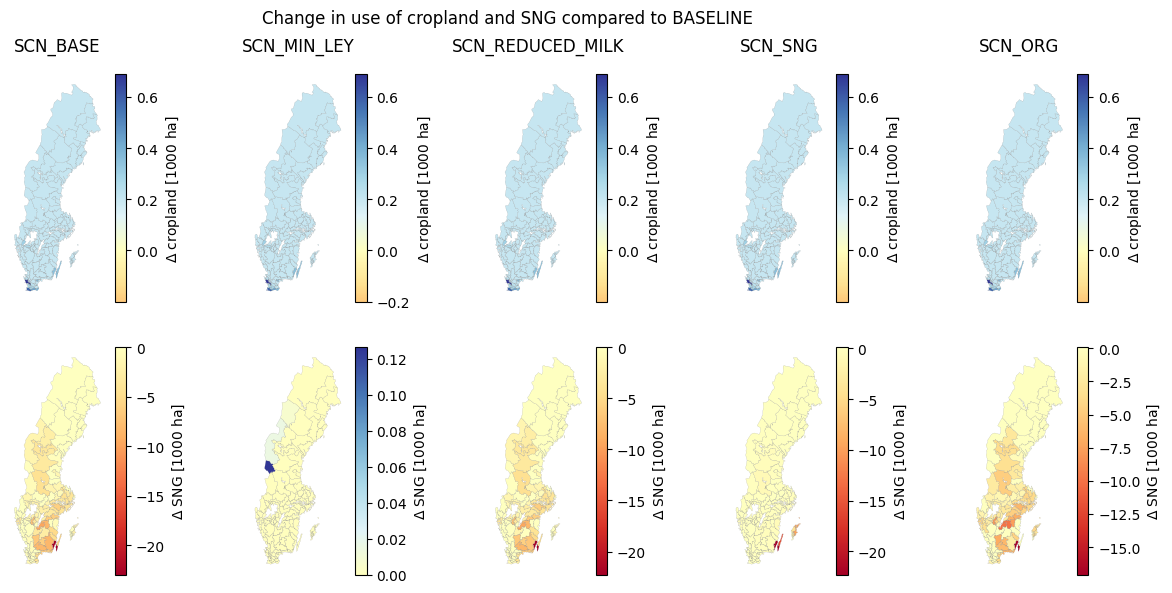

In [9]:
land_use = session.get_attr('C','area',{'region':None,'crop':'land_use'}).droplevel("year")
land_use = (land_use - land_use.loc['BASELINE'])

scenarios = [scn for scn in session.scenarios() if scn != "BASELINE"]
n_scn = len(scenarios)
fig, axs2d = plt.subplots(2, n_scn, figsize=(n_scn * 3, 6.5))

vmins = { k: land_use.T.xs(k, level="land_use").T.min().min() for k in ["cropland", "semi-natural grasslands"] }
vmaxs = { k: land_use.T.xs(k, level="land_use").T.max().max() for k in ["cropland", "semi-natural grasslands"] }

for scn, axs in zip(scenarios, axs2d.T):
    axs[0].set_title(scn)
    for ax, land_type in zip(axs, ["cropland", "semi-natural grasslands"]):
        data = land_use.loc[scn,:].xs(land_type, level="land_use") / 1e3
        lim = abs(data).quantile(0.99)
        ax.set_axis_off()
        lt = "SNG" if land_type == "semi-natural grasslands" else land_type
        plot.map_from_series(
            data, ax=ax, 
            cmap='RdYlBu', edgecolor='grey', legend_kwds={'label': fr'$\Delta$ {lt} [1000 ha]'},
            cmap_zero_midpoint="shrink"#,
            #vmin=vmins[land_type], vmax=vmaxs[land_type]
        )
    fig.suptitle("Change in use of cropland and SNG compared to BASELINE")


### Landuse of Ley and Cereals

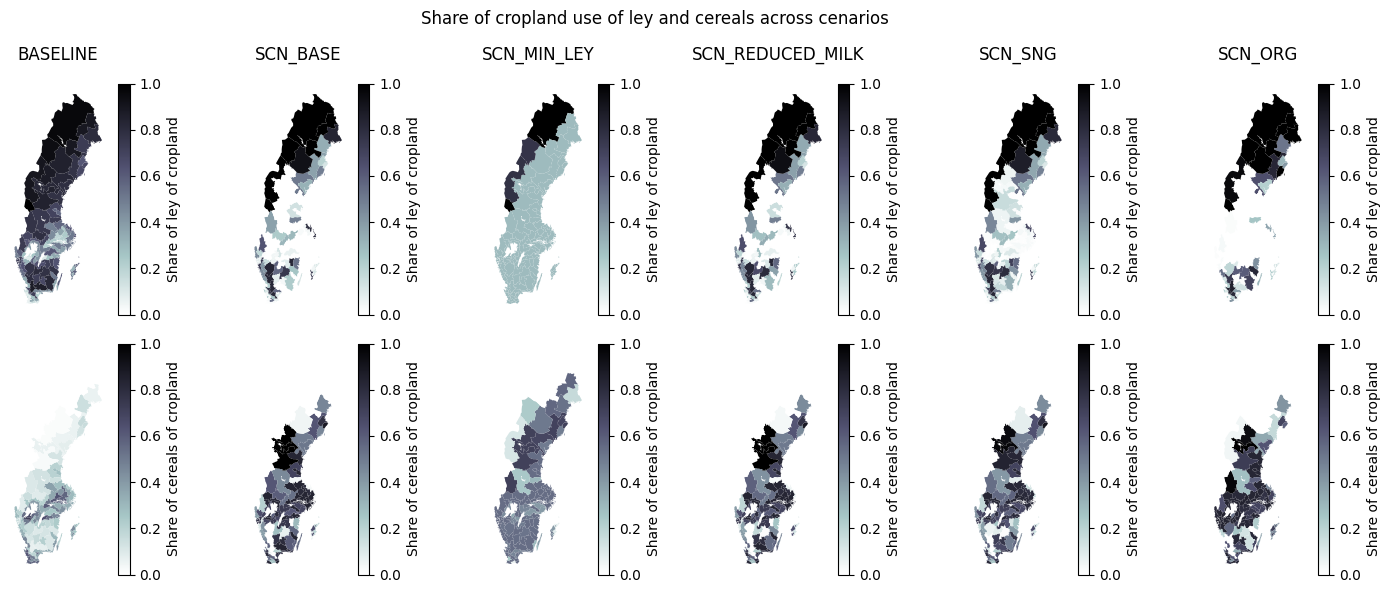

In [10]:
landuse_df = pd.concat({
    "ley": session.get_attr('C','area',groupby={'crop':'crop_group', "region": None}).droplevel("year")["Ley"],
    "cereals": session.get_attr('C','area',groupby={'crop':'crop_group', "region": None}).droplevel("year")[["Cereals, spring", "Cereals, winter"]].T.groupby("region").sum().T,
}, axis=1)
cropland_df = session.get_attr('C','area',groupby={'crop':'land_use', "region": None}).T.xs("cropland", level="land_use").T.droplevel("year")
rel_landuse_df = landuse_df/cropland_df

n_scn = len(rel_landuse_df.index)
fig, axs2d = plt.subplots(2, n_scn, figsize=(2.5*n_scn, 6))
for scn, axs in zip(rel_landuse_df.index, axs2d.T):
    axs[0].set_title(scn)
    for cg, ax in zip(["ley", "cereals"], axs):
        data = rel_landuse_df.loc[scn,(cg,slice(None))]
        ax.set_axis_off()
        plot.map_from_series(data, ax=ax, cmap="bone_r", vmin=0, vmax=1, legend_kwds={"label": fr"Share of {cg} of cropland"})

fig.suptitle("Share of cropland use of ley and cereals across cenarios")
fig.tight_layout()

## Change in crops

Plots if crops increased or decarsed in amounts in each region. 

**Disabled** because it takes about 2-3 minutes to run.

### Change in total crops per region, compared to x0

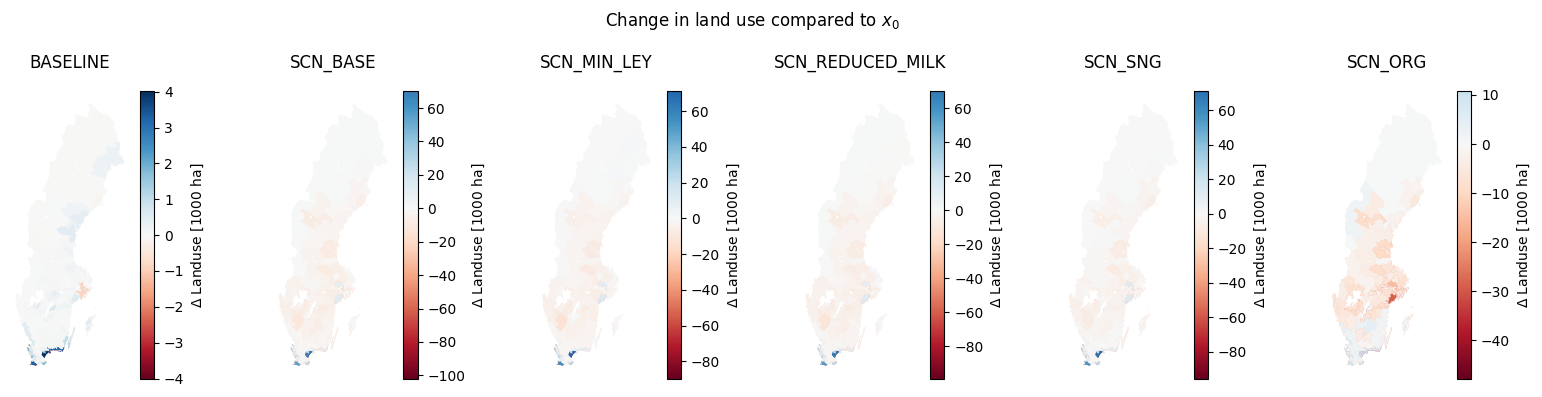

In [11]:
x0_crops_per_region = session.get_attr("r", "x0_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
x_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
delta = x_crops_per_region - x0_crops_per_region

fig, axs = plt.subplots(1, len(session.scenarios()), figsize=(16, 4))
for scn, ax in zip(list(session.scenarios().keys()), axs):
    try:
        data = delta.loc[(scn, "2020"),:] / 1e3
    except Exception:
        continue
    
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(data, cmap="RdBu", ax=ax, cmap_zero_midpoint="shrink", legend_kwds={ "label": r"$\Delta$ Landuse [1000 ha]" })

fig.suptitle(r"Change in land use compared to $x_0$")
fig.tight_layout()

### Change in total crops per region, compared to the baseline

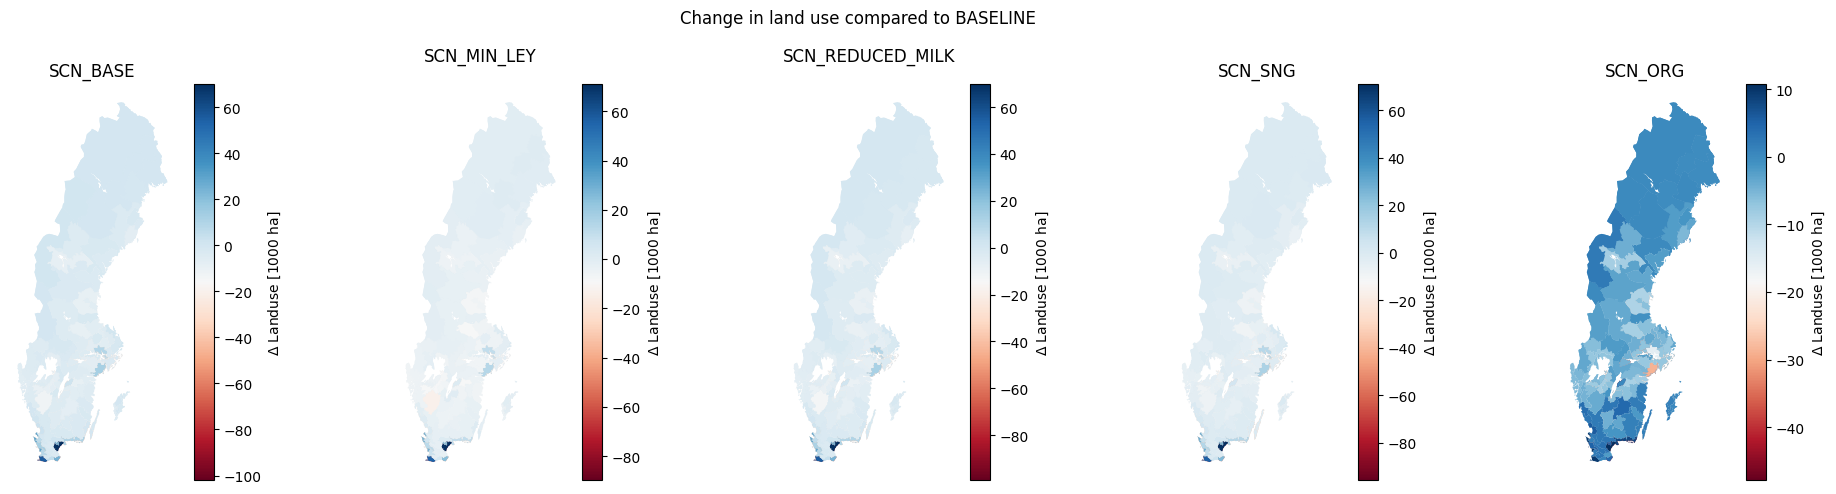

In [12]:
BL_crops_per_region = session.get_attr("r", "x0_crops", ["prod_system", "region"], scn="BASELINE").loc[("BASELINE","2020")]
SCNS_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
SCNS_crops_per_region = SCNS_crops_per_region.drop([("BASELINE", "2020")])
delta = SCNS_crops_per_region - BL_crops_per_region

scenarios = [scn for scn in session.scenarios() if scn != "BASELINE"]
fig, axs = plt.subplots(1, len(scenarios), figsize=(20, 5))
for scn, ax in zip(scenarios, axs):
    ax.set_axis_off()
    ax.set_title(scn)
    
    try:
        data = delta.loc[(scn, "2020"),:] / 1e3
    except Exception:
        continue
    
    plot.map_from_series(data, cmap="RdBu", ax=ax, legend_kwds={ "label": r"$\Delta$ Landuse [1000 ha]" })

fig.suptitle("Change in land use compared to BASELINE")
fig.tight_layout()

## Byproducts

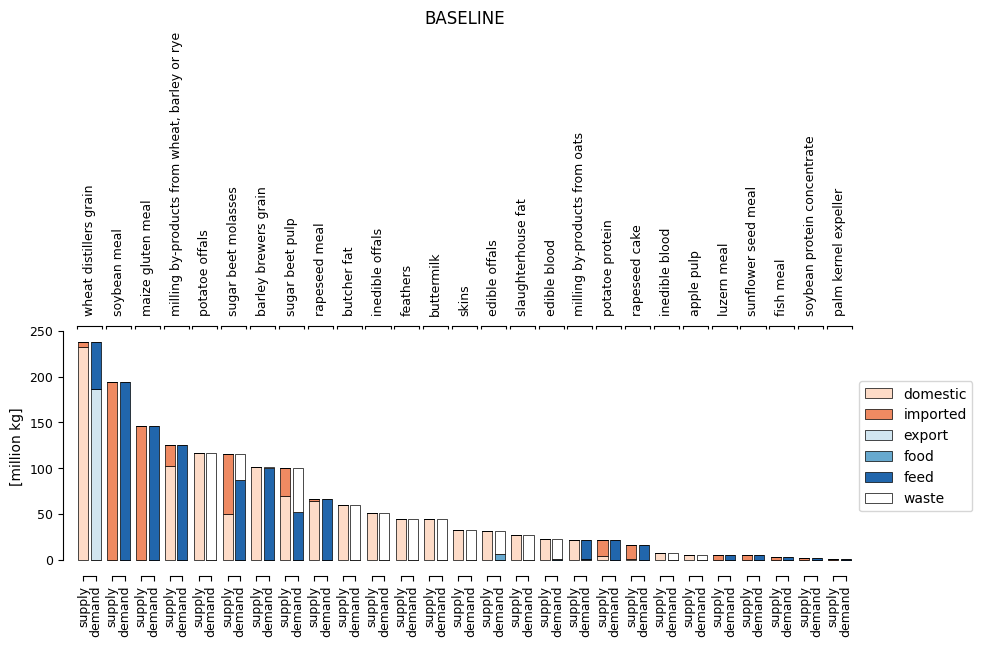

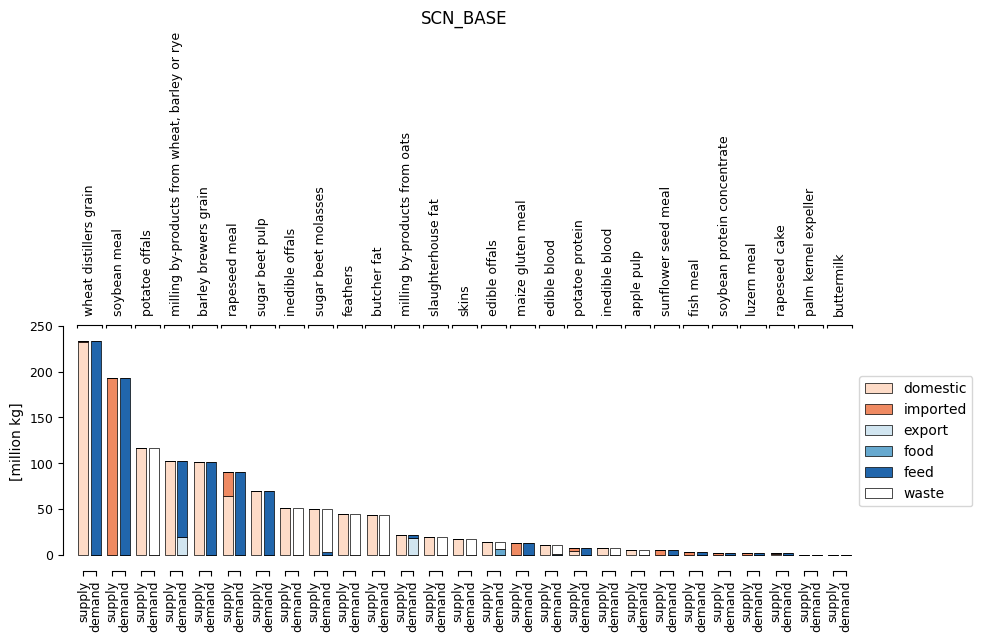

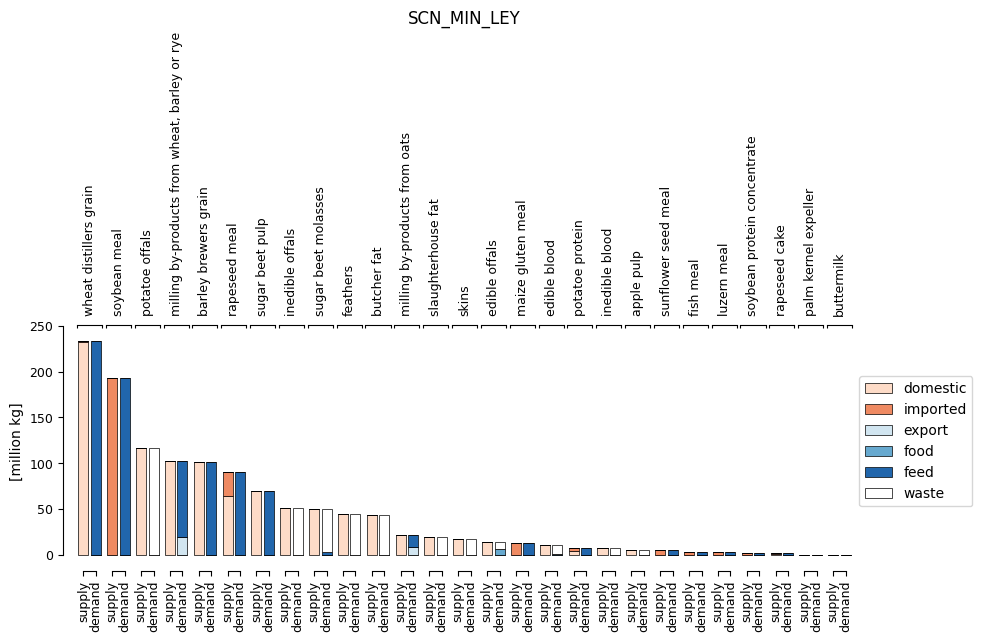

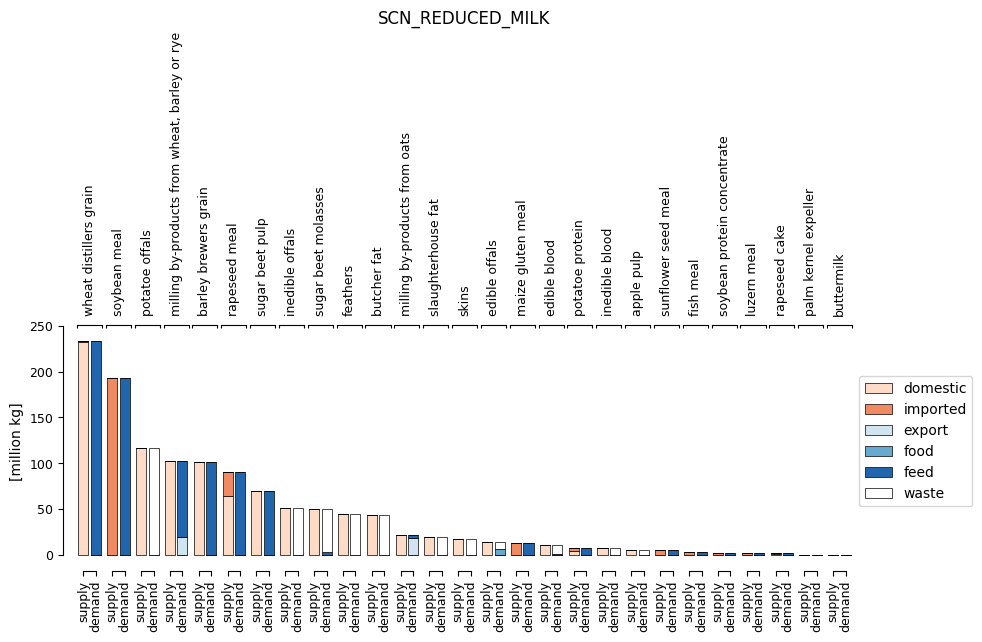

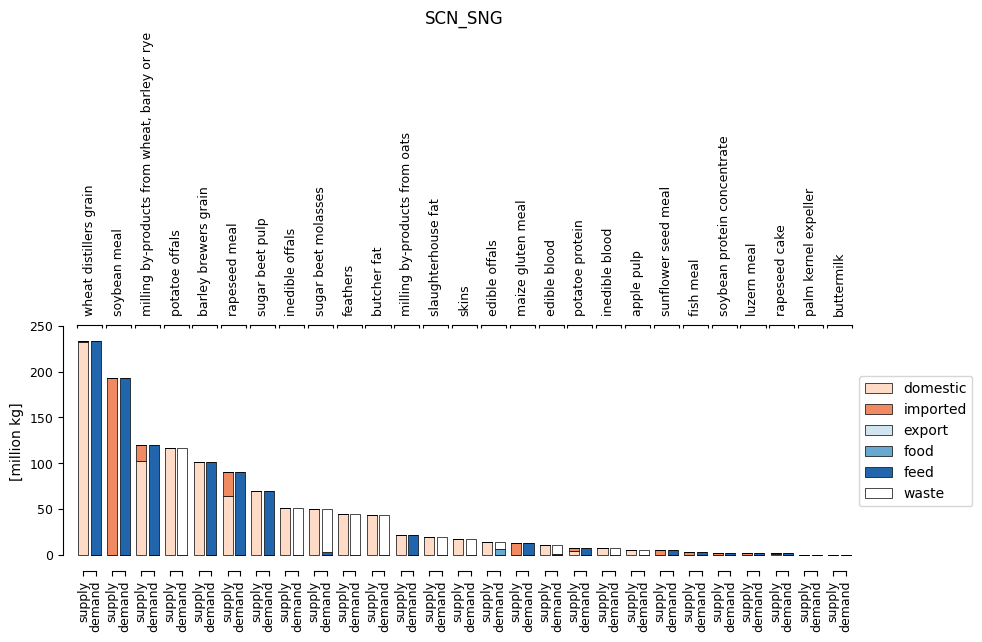

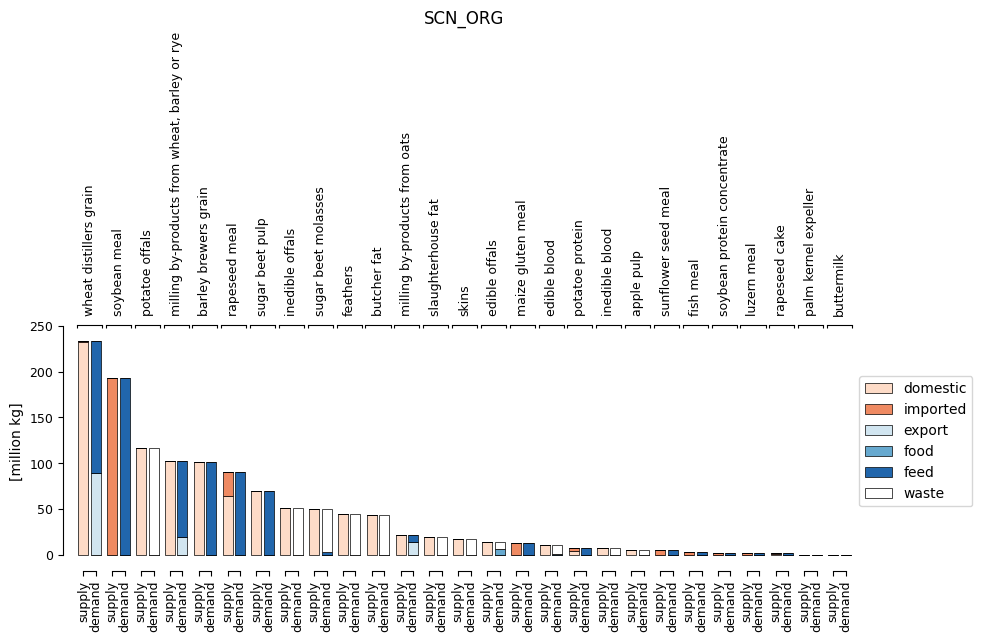

In [13]:
from matplotlib.colors import ListedColormap

for scn in session.scenarios():
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    use = pd.concat([
        # By product demand
        session.get_attr('D', 'by_prod_demand', ['by_prod', 'demand']).loc[(scn,"2020")].unstack(fill_value=0),
        # Feed
        session.get_attr('A', 'feed.by_product_demand', 'by_prod')
        .loc[(scn,"2020")]
        .rename('feed'),
        # Waste
        session.get_attr('D', 'by_prod_to_waste', 'by_prod').loc[(scn,"2020")]
        .rename('waste')
    ], axis=1).fillna(0).rename_axis('origin', axis=1)
    
    supply = (
        session.get_attr('D', 'by_products', ['by_prod', 'origin'])
        .loc[(scn,"2020")]
        .unstack()
        .fillna(0)
    )
    
    plot_data = (
        pd.concat([
            pd.concat({'supply': supply}, names=['flow'], axis=1),
            pd.concat({'demand': use }, names=['flow'], axis=1),
        ], axis=1)
        .stack('flow')
        .sort_index(level='flow', ascending=False)
        .sort_index(level='by_prod', sort_remaining=False)
        .fillna(0)
        / 1e6
    )
    
    colors = ['#fddbc7', '#ef8a62', '#d1e5f0', '#67a9cf', '#2166ac', '#ffffff']
    cust_cmap = ListedColormap(name='X', colors=colors)
    
    ax, axgs = cm.plot.bar(
        plot_data.drop('whey'),
        ax=ax,
        cmap = cust_cmap,
        group_levels='by_prod',
        sort_groups=True,
        grouplabels_vertical=True,
        group_spacing = 0.3,
        ticklabels_fontsize = 9,
        grouplabels_fontsize = 9,
        ylabel_fontsize = 10,
        xlabel_fontsize = 10
    )
    ax.set_ylabel("[million kg]")
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_title(scn)
    fig.show()


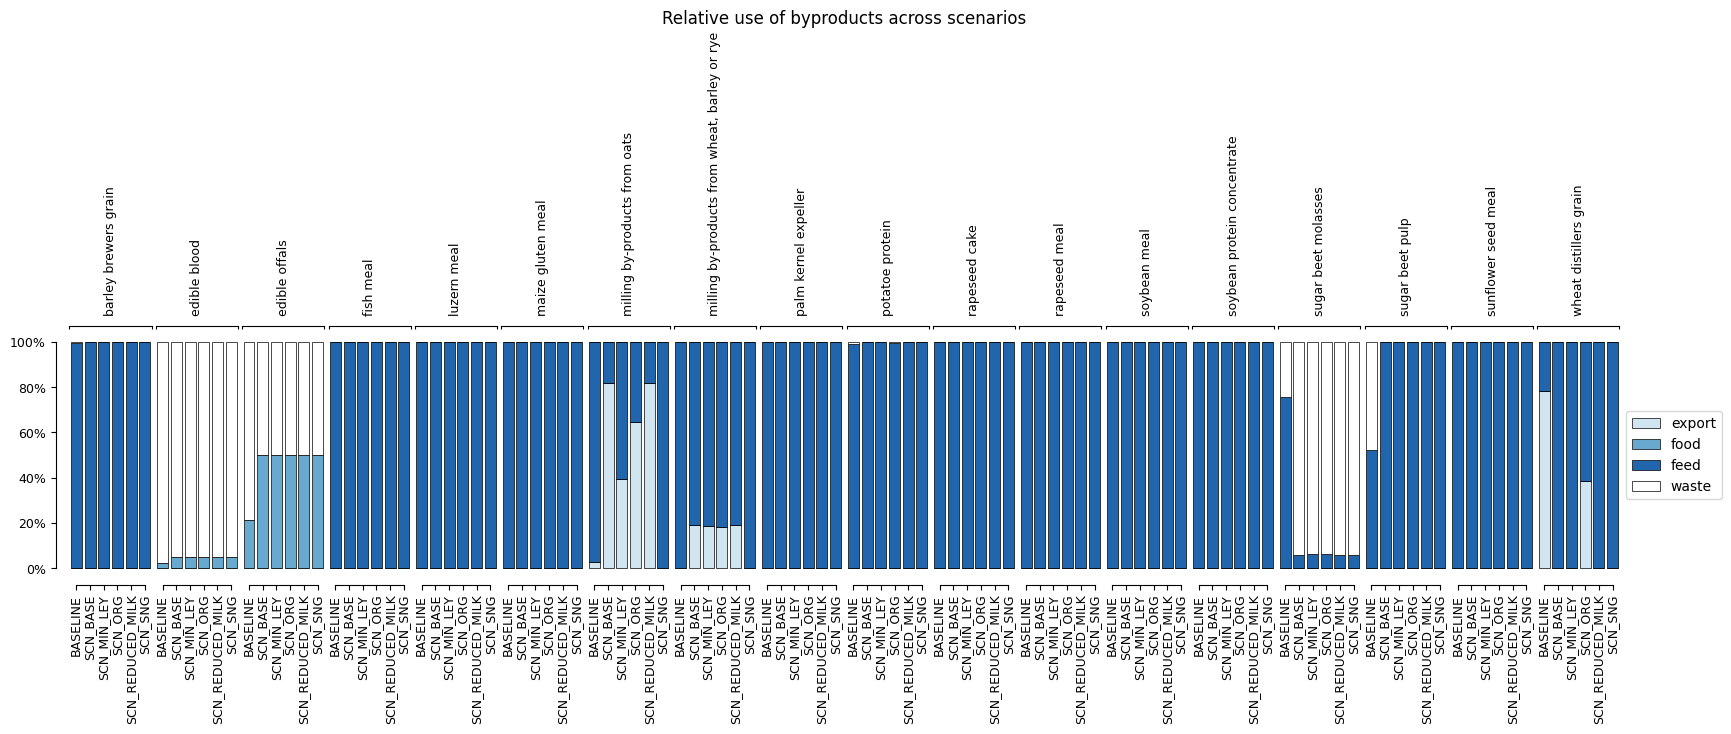

In [14]:
from matplotlib.colors import ListedColormap

AS_PERC=True

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
def get_use(scn: str):
    return pd.concat([
        # By product demand
        session.get_attr('D', 'by_prod_demand', ['by_prod', 'demand']).loc[(scn,"2020")].unstack(fill_value=0),
        # Feed
        session.get_attr('A', 'feed.by_product_demand', 'by_prod')
        .loc[(scn,"2020")]
        .rename('feed'),
        # Waste
        session.get_attr('D', 'by_prod_to_waste', 'by_prod').loc[(scn,"2020")]
        .rename('waste')
    ], axis=1).fillna(0).rename_axis('origin', axis=1)

plot_data = (
    pd.concat([
        pd.concat({scn: get_use(scn)}, names=['flow'], axis=1) 
        for scn in session.scenarios()
    ], axis=1)
    .stack('flow')
    .sort_index(level='flow', ascending=True)
    .sort_index(level='by_prod', sort_remaining=False)
    .fillna(0)
    / 1e6
)

plot_data = plot_data[plot_data.sum(axis=1) > 0]

if AS_PERC:
    plot_data = (plot_data.T /  plot_data.T.sum()).T
    plot_data = plot_data[plot_data.loc[:, "waste"] != 1]

colors = ['#d1e5f0', '#67a9cf', '#2166ac', '#ffffff']
cust_cmap = ListedColormap(name='X', colors=colors)

ax, axgs = cm.plot.bar(
    plot_data.drop('whey'),
    ax=ax,
    cmap = cust_cmap,
    group_levels='by_prod',
    sort_groups=True,
    grouplabels_vertical=True,
    group_spacing = 0.3,
    ticklabels_fontsize = 9,
    grouplabels_fontsize = 9,
    ylabel_fontsize = 10,
    xlabel_fontsize = 10
)
    
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

if AS_PERC:
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
else:
    ax.set_ylabel("[million kg]")

ax.set_title(f"{'Relative u' if AS_PERC else 'U'}se of byproducts across scenarios")

fig.show()

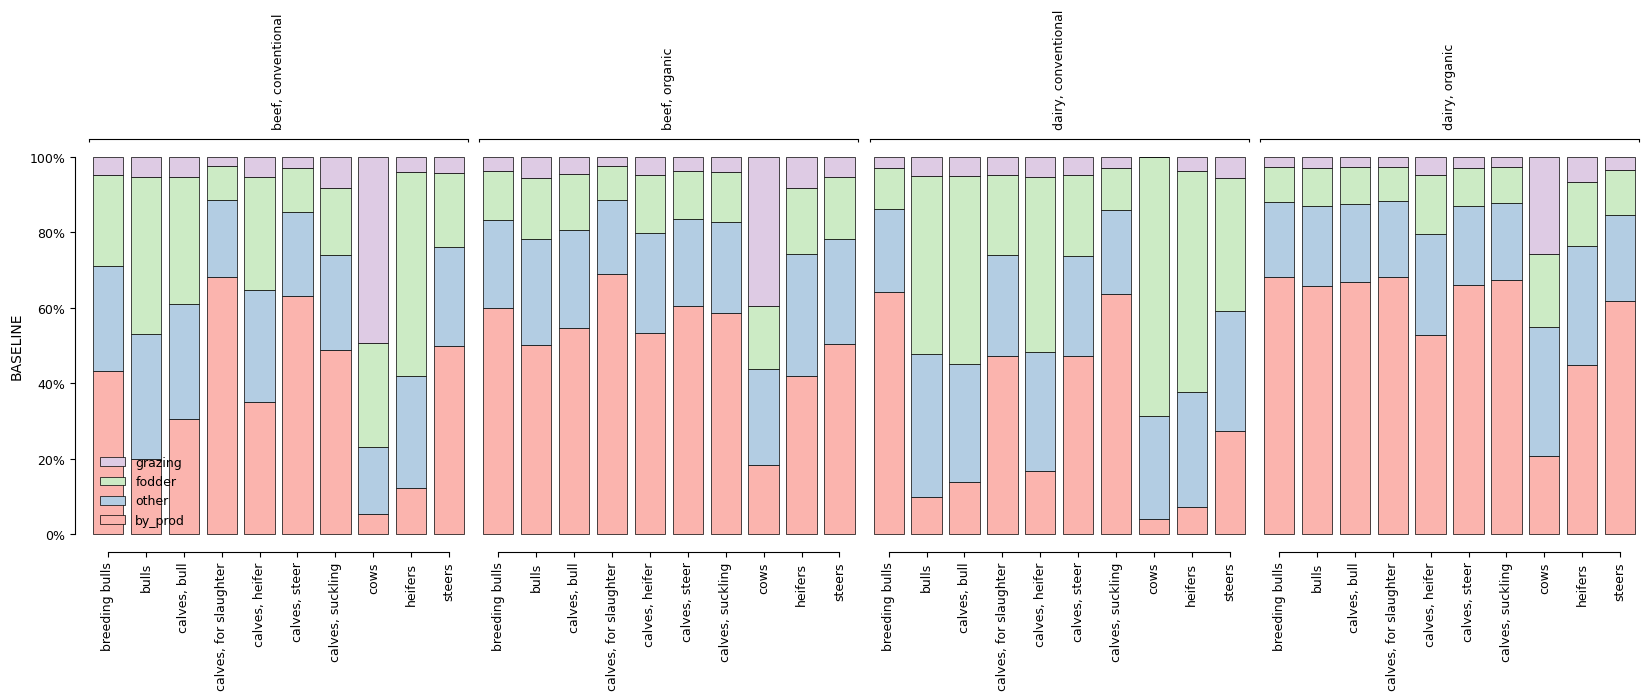

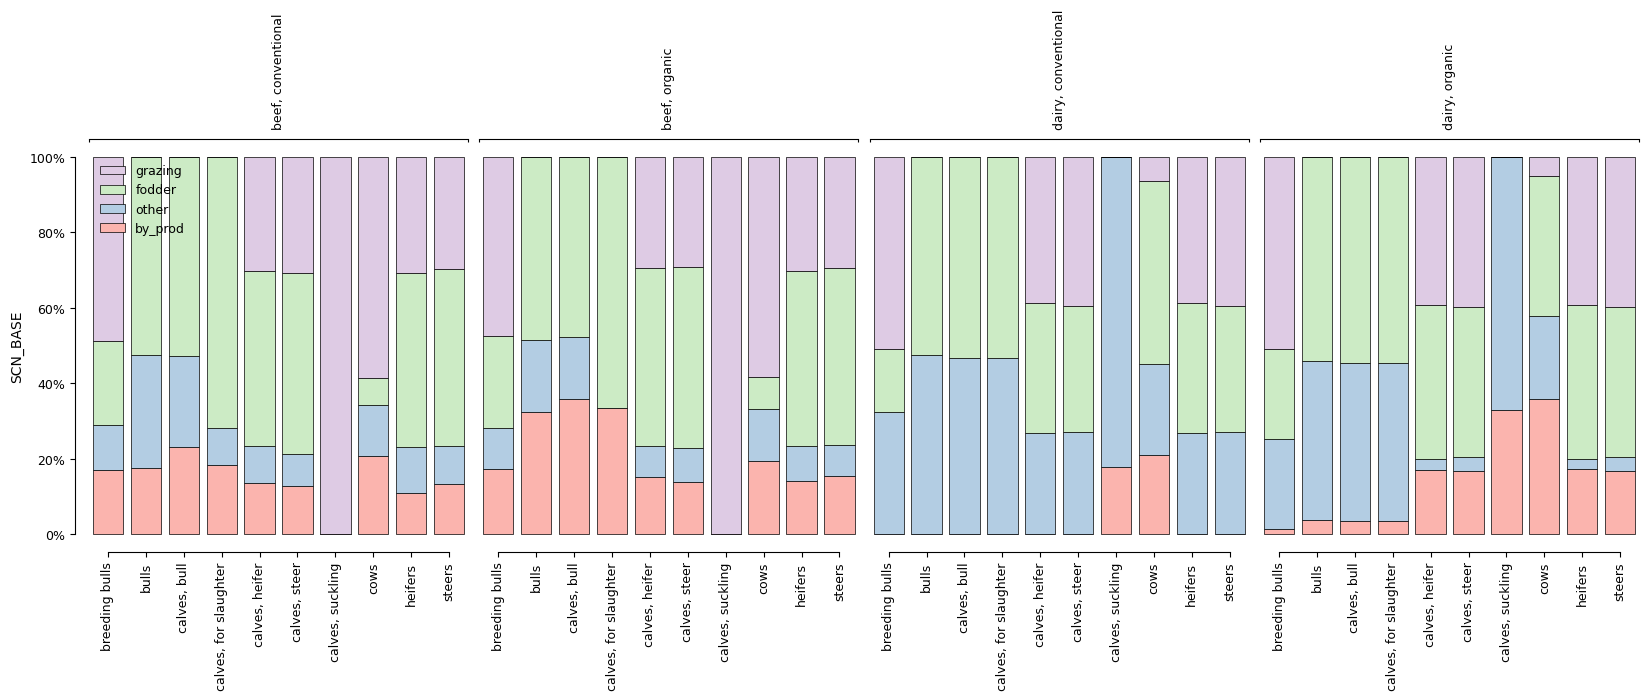

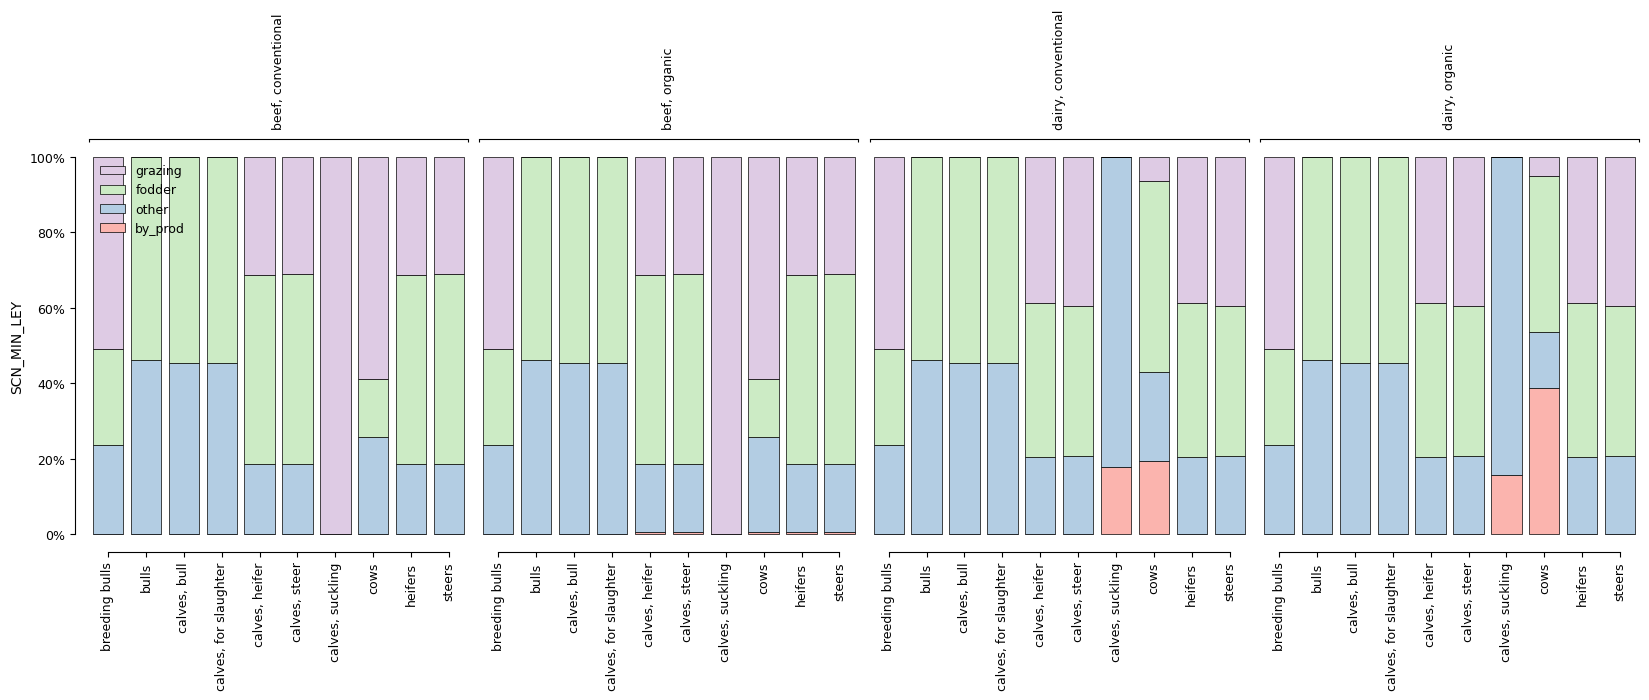

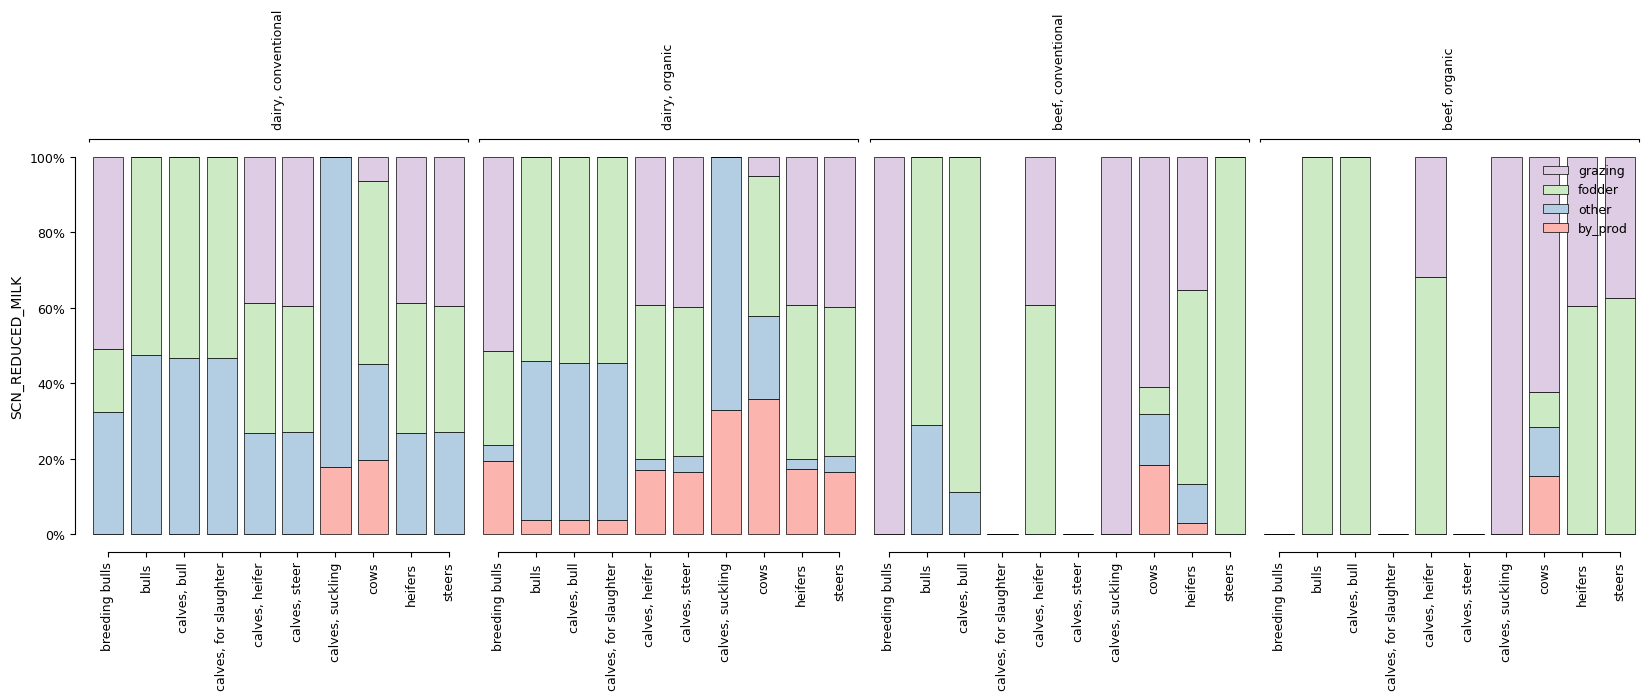

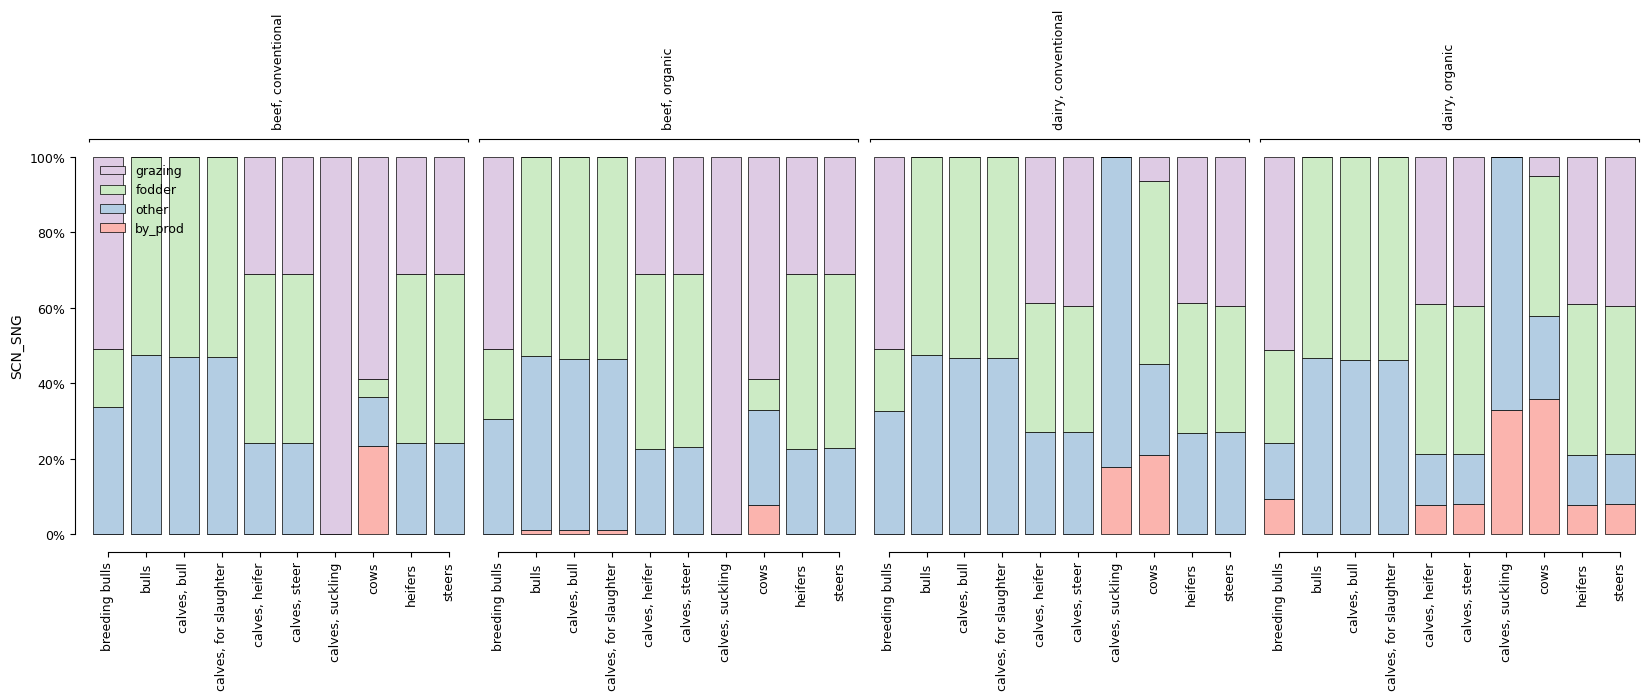

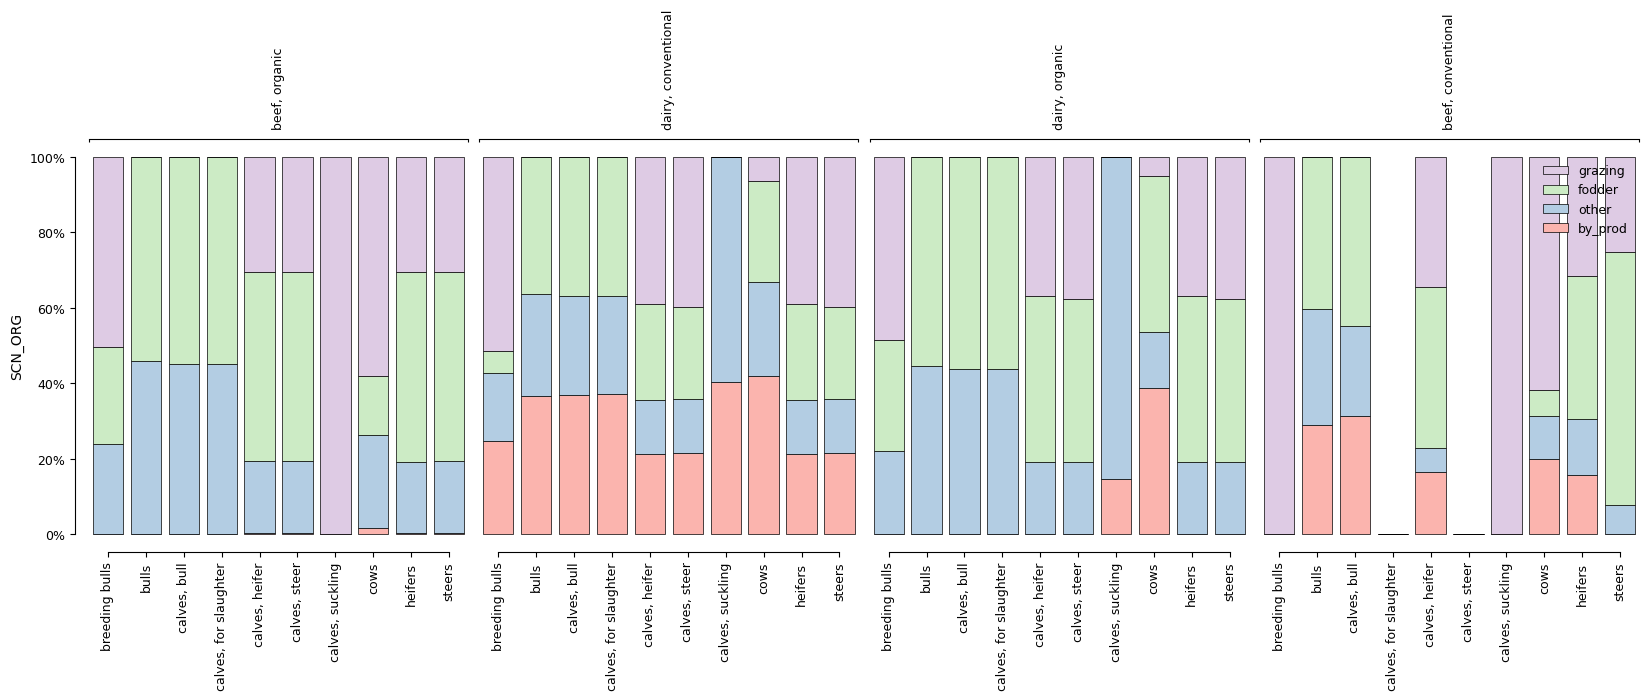

In [15]:
base_data = lambda prod_type: session.get_attr('A', f'feed.{prod_type}_demand').droplevel("year").T.xs("cattle", level="species")
byprods = base_data("by_product").groupby(["breed", "prod_system", "animal"]).sum().T
cps_all = base_data("crop_product").groupby(["breed", "prod_system", "animal"]).sum().T
cps_fodder = base_data("crop_product").xs("fodder", level="crop_prod").groupby(["breed", "prod_system", "animal"]).sum().T
cps_grazing = base_data("crop_product").xs("grazing", level="crop_prod").groupby(["breed", "prod_system", "animal"]).sum().T

cps_other = cps_all - cps_fodder - cps_grazing
feed_total = byprods + cps_all

assert all(map(lambda df: df.columns.names == byprods.columns.names, [feed_total, cps_all, cps_fodder, cps_grazing, cps_other]))

rel = lambda df: (df / feed_total.replace({ 0: np.inf }))

shares = pd.concat(
    {
        "by_prod": rel(byprods),
        "other": rel(cps_other),
        "fodder": rel(cps_fodder),
        "grazing": rel(cps_grazing),
    },
    names=["feed_group", *cps_all.columns.names],
    axis=1,
).fillna(0)

for scn in session.scenarios():
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    cm.plot.bar(
        shares.loc[scn].unstack("feed_group"),
        ax=ax,
        cmap = "Pastel1",
        group_levels=["breed", "prod_system"],
        sort_groups=True,
        grouplabels_vertical=True,
        group_spacing = 0.3,
        ticklabels_fontsize = 9,
        grouplabels_fontsize = 9,
        ylabel_fontsize = 10,
        xlabel_fontsize = 10
    )
    ax.set_ylabel(scn)
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))

# cereals, legumes, grazing, fodder, byprods, other

## Protein production

milk          meat    Peas (add)   Wheat (add)
scn                                                                     
BASELINE          9.860058e+10  2.109306e+10  0.000000e+00  0.000000e+00
SCN_BASE          6.367552e+10  7.346333e+09  2.542755e+11  3.253653e+11
SCN_MIN_LEY       6.693690e+10  2.121332e+10  2.532365e+11  2.041291e+11
SCN_REDUCED_MILK  6.184299e+10  8.969464e+09  2.542793e+11  3.192839e+11
SCN_SNG           6.367587e+10  1.181082e+10  2.527564e+11  3.145708e+11
SCN_ORG           1.816356e+10  4.806190e+09  2.456445e+11  3.515001e+11

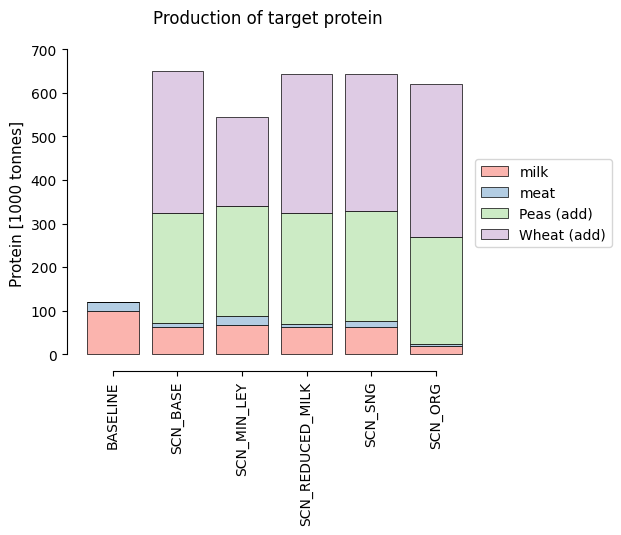

In [16]:
production = pd.concat([
    session.get_attr("a", "production").T.xs("cattle", level="species").groupby("animal_prod").sum().T[["milk", "meat"]],
    session.get_attr("c", "harvest", "crop")[["Peas (add)", "Wheat (add)"]],
], axis=1).droplevel("year").fillna(0)#.drop("BASELINE")

for prod, factor in PROTEIN_CONTENTS.items():
    production[prod] *= factor
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot.bar(production / 1e9, stacked=True, ax=ax, cmap="Pastel1")
ax.set_ylabel("Protein [1000 tonnes]")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

fig.suptitle("Production of target protein")
display(production)

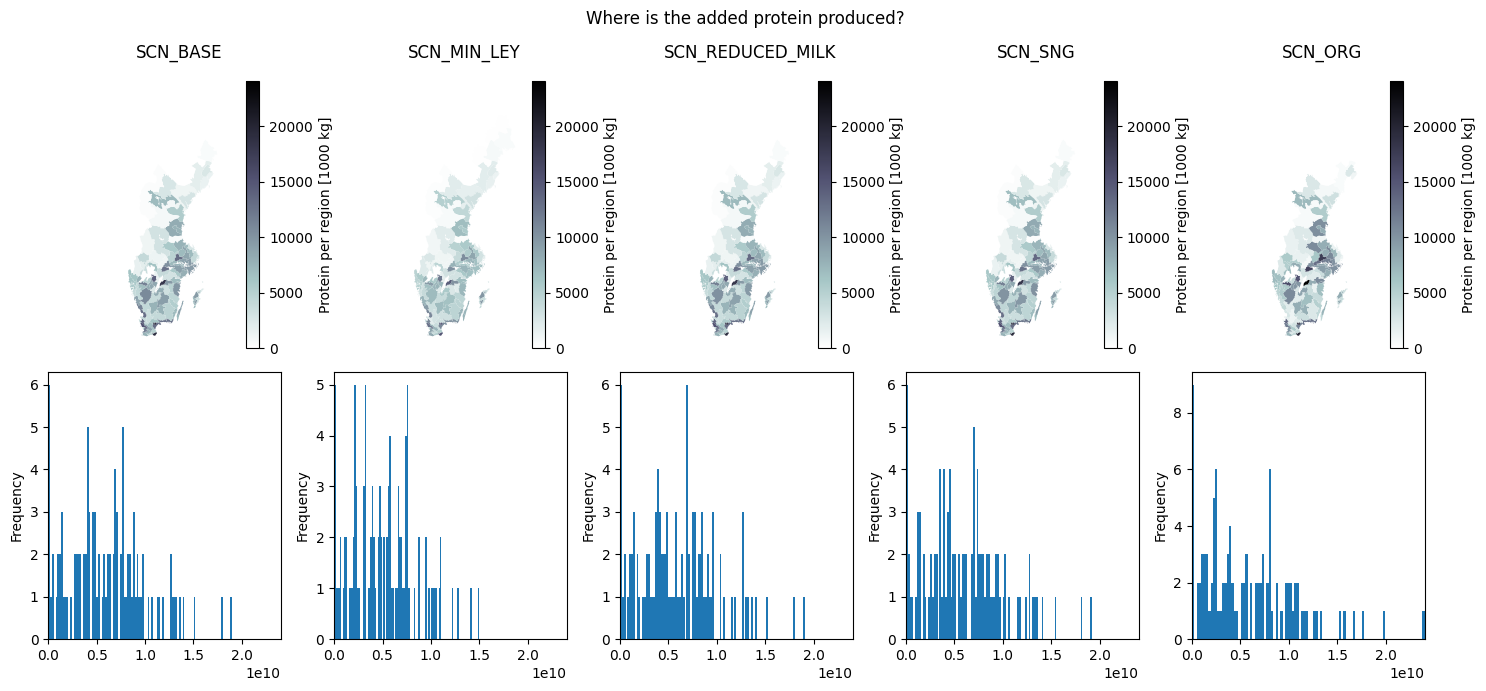

In [17]:
protein_by_region = pd.concat([
    session.get_attr("a", "production").T.xs("cattle", level="species").groupby(["animal_prod", "region"]).sum().T[["milk", "meat"]],
    session.get_attr("c", "harvest", ["crop", "region"])[["Peas (add)", "Wheat (add)"]],
], axis=1).droplevel("year").drop("BASELINE").fillna(0)

# Multiply each product by its protein contents (g protein / kg product)
for prod, factor in PROTEIN_CONTENTS.items():
    protein_by_region[prod] *= factor

# Sum across all products to get total protein amount
protein_by_region = protein_by_region.T.groupby("region").sum().T
scenarios = [scn for scn in session.scenarios() if scn != "BASELINE"]

vmin, vmax = protein_by_region.min().min(), protein_by_region.max().max()
fig, axs2d = plt.subplots(2, len(scenarios), figsize=(len(scenarios)*3, 7))

for scn, ax in zip(scenarios, axs2d[0]):
    k = 1e6
    cm.plot.map_from_series(
        protein_by_region.loc[scn] / k, 
        ax=ax, vmin=vmin/k, vmax=vmax/k, cmap="bone_r",
        legend_kwds={ "label": "Protein per region [1000 kg]" }
    )
    ax.set_axis_off()
    ax.set_title(scn)

for scn, ax in zip(scenarios, axs2d[1]):
    #protein_by_region.loc[scn].plot.kde(ax=ax)
    protein_by_region.loc[scn].plot.hist(ax=ax, bins=100)
    ax.set_xlim([vmin, vmax])
    
fig.suptitle("Where is the added protein produced?")
fig.tight_layout()

## Chloropleth maps over added crops/meat

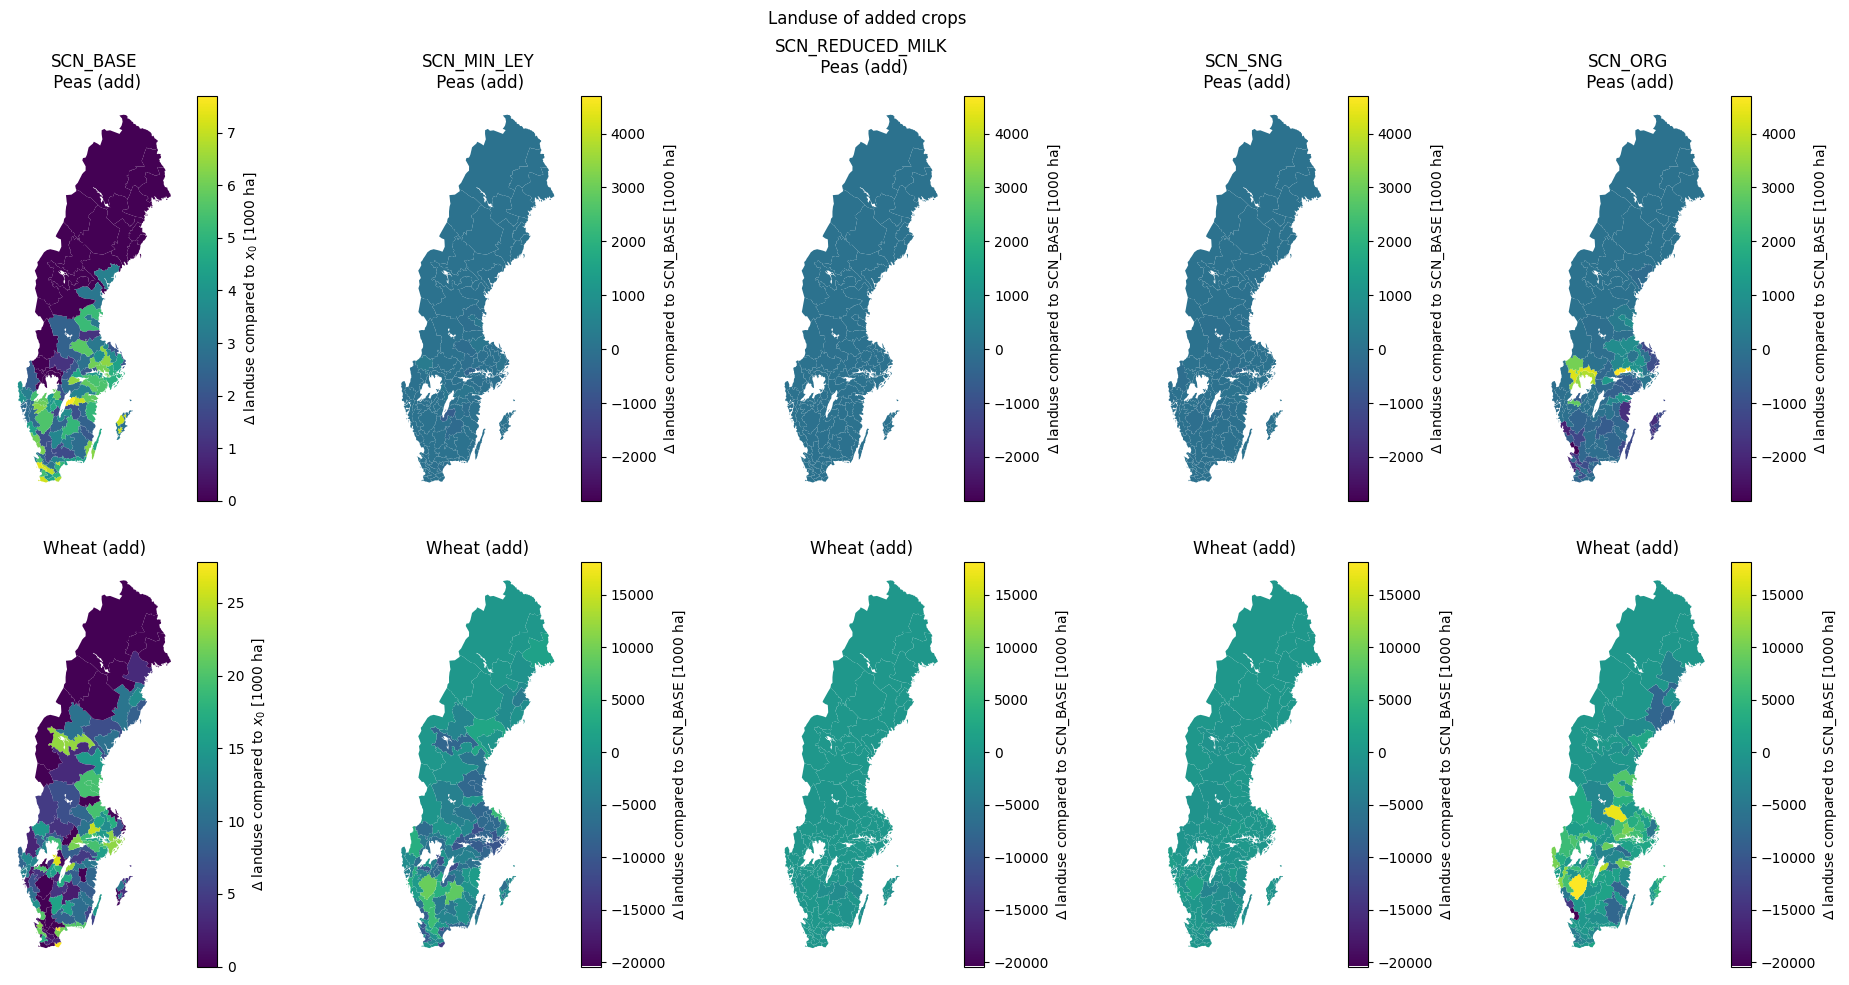

In [18]:
def get_x(crp: str):
    return session.get_attr("f", "x_crops").xs(crp, level="crop", drop_level=False, axis=1).droplevel("year")

crops = pd.concat([get_x("Peas (add)"), get_x("Wheat (add)")], axis=1)
cps = crops.columns.unique("crop")
crops = crops.drop("BASELINE")

nrows = len(cps)
ncols = crops.shape[0]
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*5))

if nrows == 1:
    axs = [axs]

vmin = {
    "Peas (add)": (crops.loc[:, ("Peas (add)", "conventional", )] - crops.loc["SCN_BASE",("Peas (add)", "conventional", )]).min().min(),
    "Wheat (add)": (crops.loc[:, ("Wheat (add)", "conventional", )] - crops.loc["SCN_BASE",("Wheat (add)", "conventional", )]).min().min(),
}
vmax = {
    "Peas (add)": (crops.loc[:, ("Peas (add)", "conventional", )] - crops.loc["SCN_BASE",("Peas (add)", "conventional", )]).max().max(),
    "Wheat (add)": (crops.loc[:, ("Wheat (add)", "conventional", )] - crops.loc["SCN_BASE",("Wheat (add)", "conventional", )]).max().max(),
}

for scn_i, scn in enumerate(crops.index):
    for crp_i, crp in enumerate(cps):
        data=crops.loc[scn,(crp, "conventional",)]
        ax=axs[crp_i][scn_i]
        ax.set_axis_off()
        title = crp
        if crp_i == 0:
            title = f"{scn}\n {title}"
        ax.set_title(title)

        if scn == "SCN_BASE":
            cm.plot.map_from_series(data / 1e3, ax=ax, legend_kwds={ "label": r"$\Delta$ landuse compared to $x_0$ [1000 ha]" })
        else:
            data = data - crops.loc["SCN_BASE",(crp, "conventional",)]
            cm.plot.map_from_series(
                data,
                ax=ax, 
                vmin=vmin[crp], vmax=vmax[crp],
                legend_kwds={ "label": r"$\Delta$ landuse compared to SCN_BASE [1000 ha]"  })

fig.suptitle("Landuse of added crops")
fig.tight_layout()

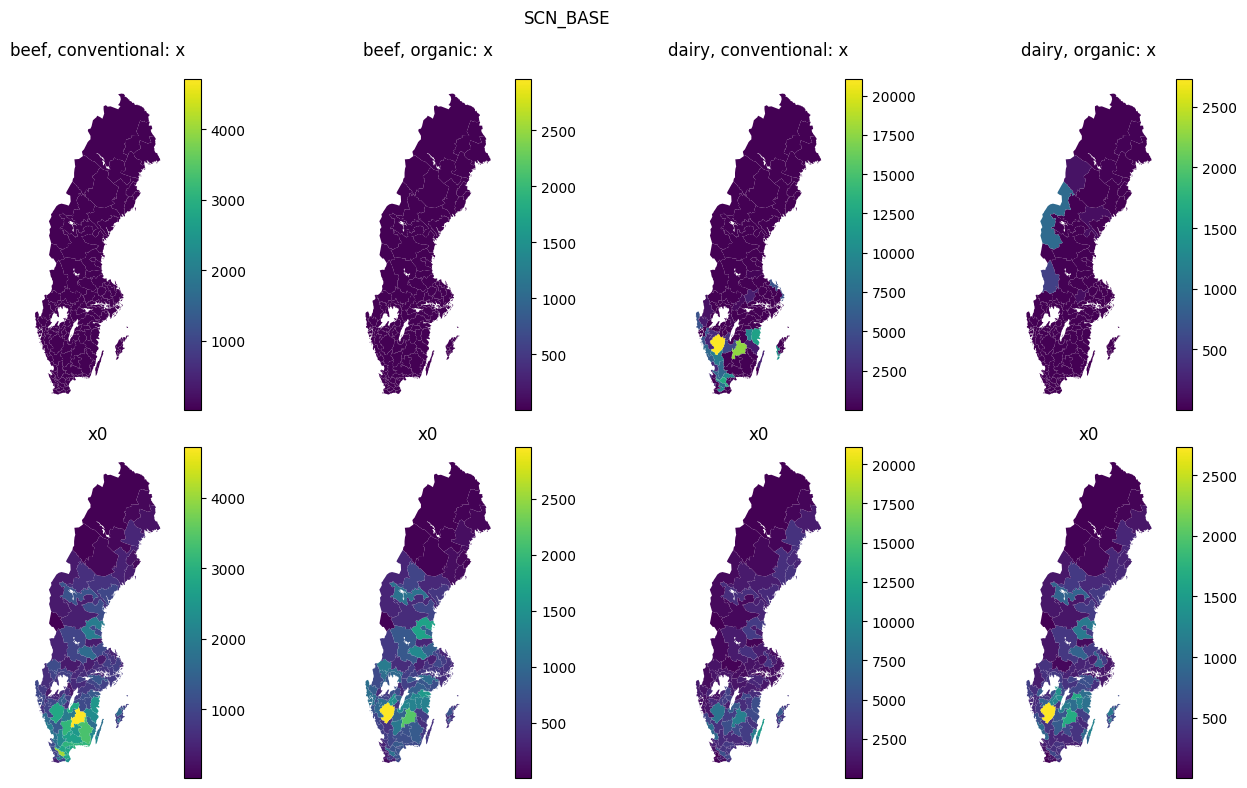

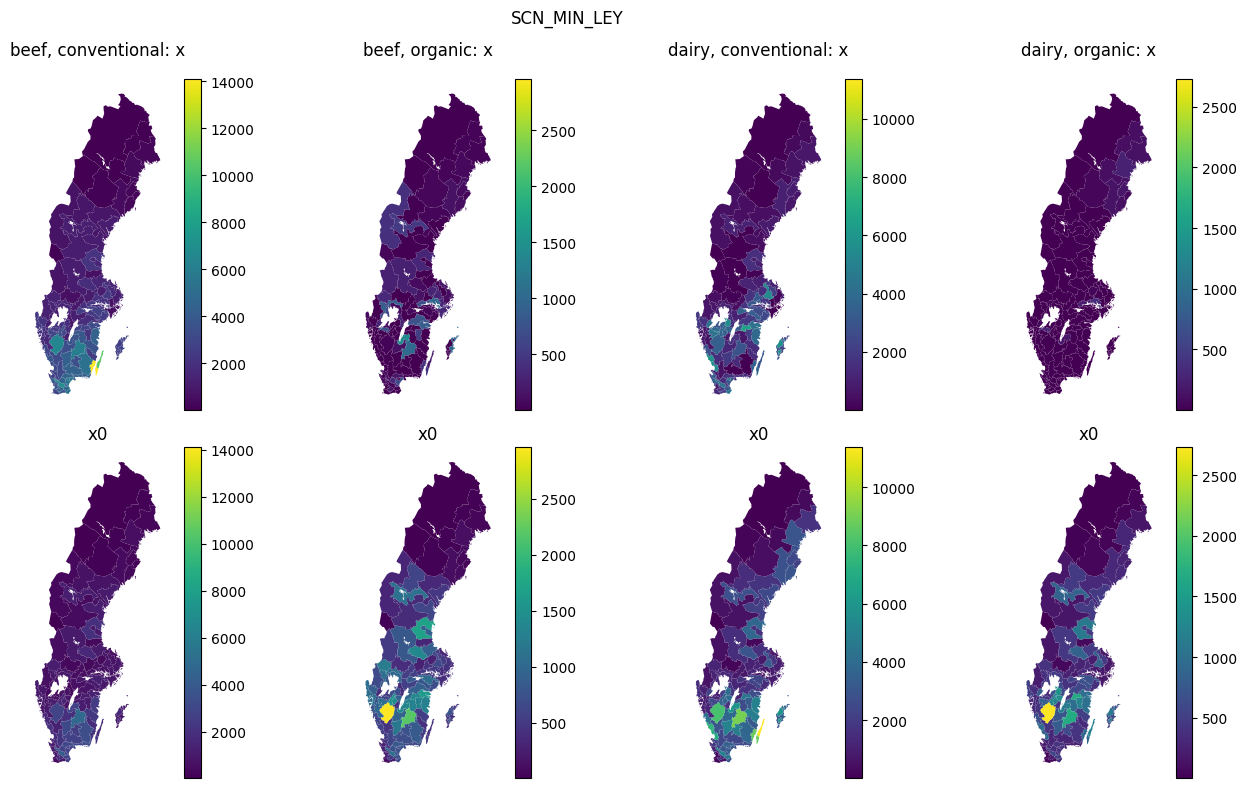

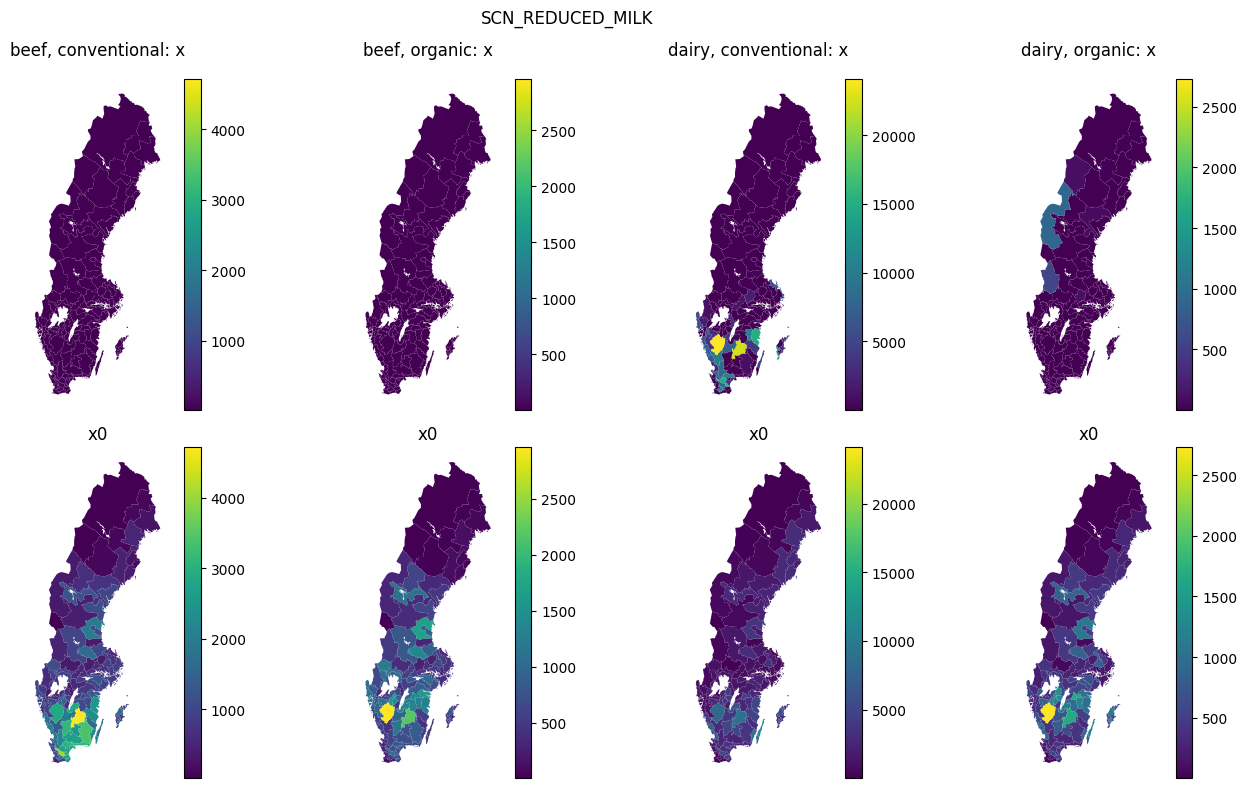

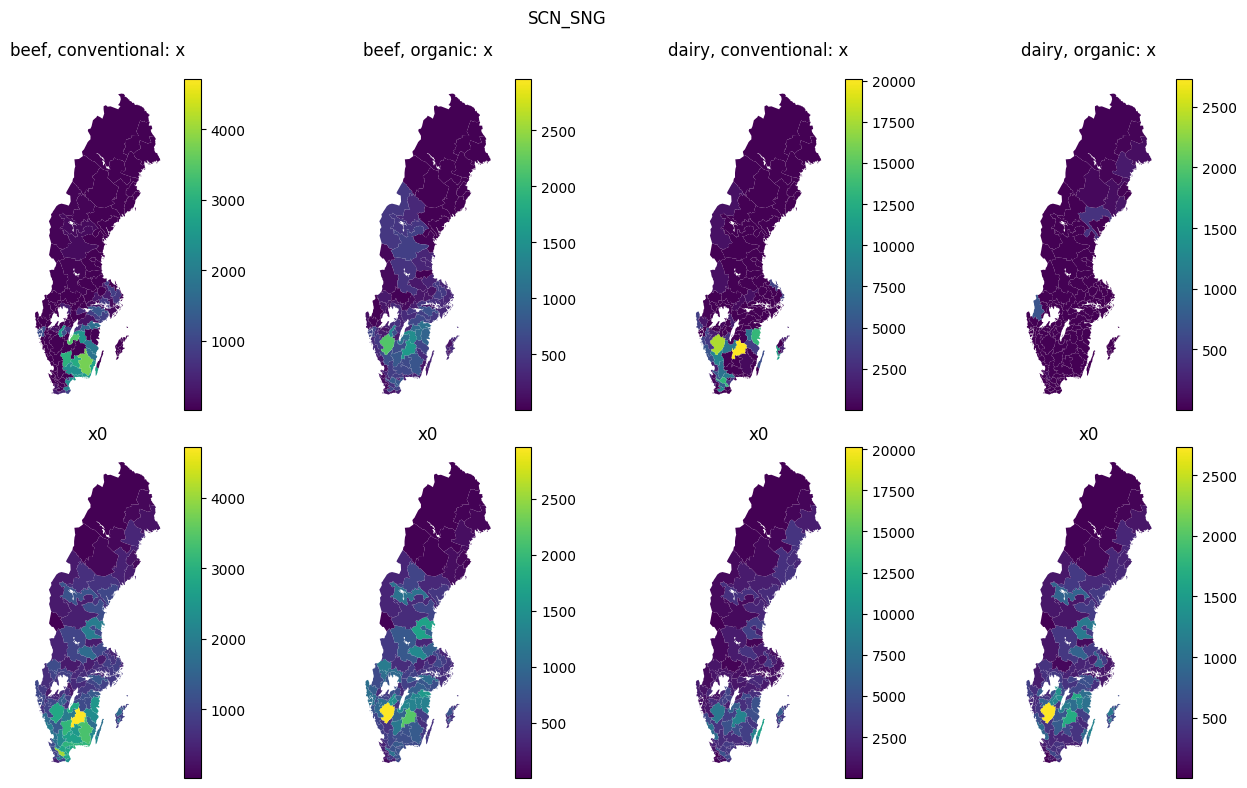

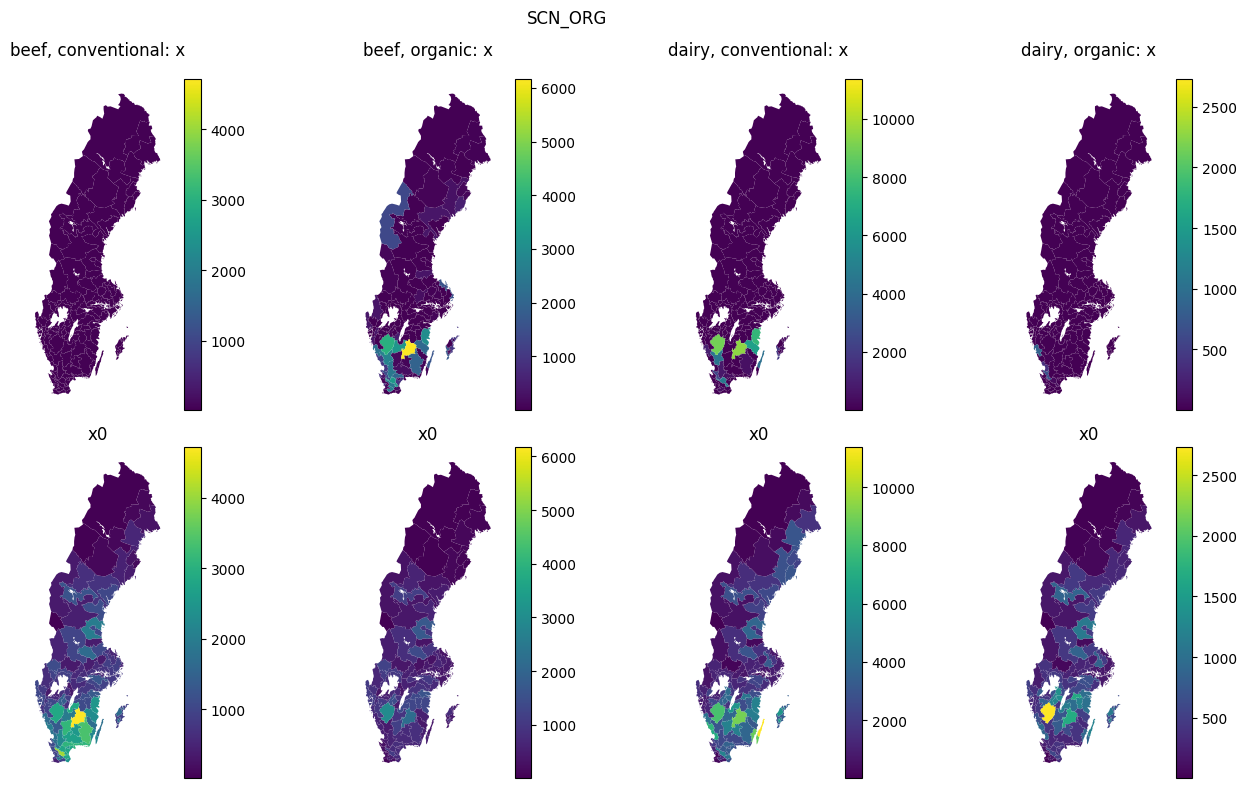

In [19]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

all_x0_cattle = session.get_attr("r", "x0_animals").xs("cattle", level="species", axis=1)
all_x_cattle = session.get_attr("f", "x_animals", ["species", "breed", "prod_system", "region"]).xs("cattle", level="species", axis=1)

for scn in all_x_cattle.index.get_level_values("scn"):
    if scn == "BASELINE": 
        continue
    
    x0_cattle = all_x0_cattle.loc[(scn, "2020")].unstack("region")
    x_cattle = all_x_cattle.loc[(scn, "2020")].unstack("region")
    
    assert (x0_cattle.index == x_cattle.index).all(), "Expected index of x0 and x to match"
    
    N = len(x0_cattle.index.values)
    fig, axes2d = plt.subplots(2, N, figsize=(N * 3.5, 8))
    
    for pos, axs in zip(x0_cattle.index, axes2d.T):
        (ax_x, ax_x0) = axs
        
        x = x_cattle.loc[pos,:]
        x0 = x0_cattle.loc[pos,:]
    
        # Absolute values: x and x0
        # -------------------------
        ax_x.set_axis_off()
        ax_x0.set_axis_off()
        x_vmax = max(x.max(), x0.max())
        x_vmin = max(x.min(), x0.min())
        ax_x.set_title(f"{pos[0]}, {pos[1]}: x")
        ax_x0.set_title("x0")
        cm.plot.map_from_series(x, ax=ax_x, vmin=x_vmin, vmax=x_vmax)
        cm.plot.map_from_series(x0, ax=ax_x0, vmin=x_vmin, vmax=x_vmax)

    fig.suptitle(scn)
    fig.tight_layout()
    plt.show()

# Impacts

## Greenhouse gases

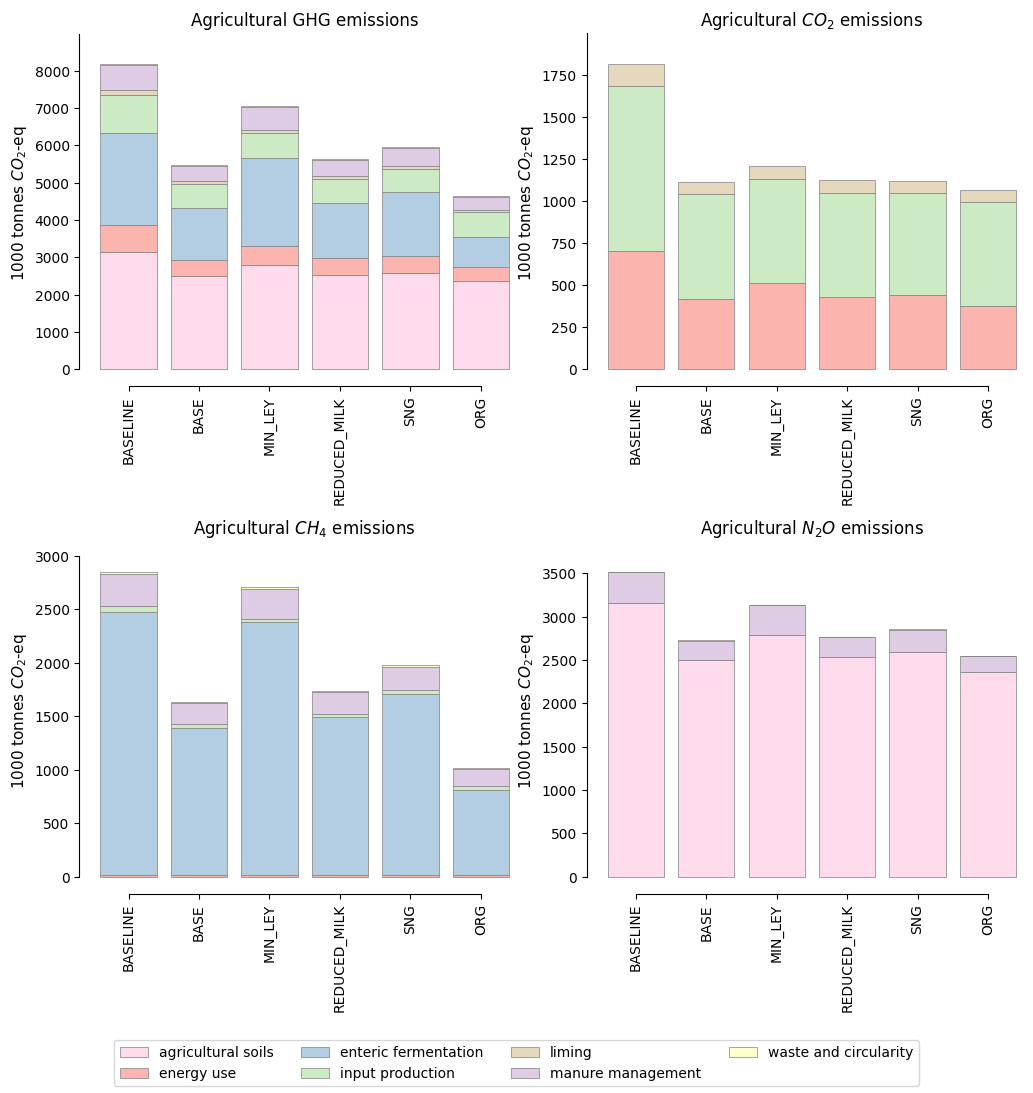

In [20]:
import matplotlib as mpl

ghg_impacts = (
    cm.impact.get_GHG(session)
    .T.groupby(['compound','process']).sum().T
    .droplevel('year')
)/1e6

def plot_ghg(
    ghgs: list[str] | str | slice,
    title: str,
    ax: plt.Axes | None = None,
    color_map: dict[str, tuple] | None = None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,6))

    if isinstance(ghgs, str):
        ghgs = [ghgs]

    data = ghg_impacts.loc[:,ghgs].T.groupby('process').sum().T

    plot.bar(
        data=data,
        ax=ax,
        edgecolor='grey',
        cmap="Pastel1"
    )

    ax.axhline(
        y=data.sum(axis=1).loc["BASELINE"],
        xmin=0, xmax=1, zorder=0, 
        linestyle='--', linewidth=0.8, color='lightgrey'
    )

    # Manually set color of each bar to the defined color_map
    if color_map:
        n_scenarios = len(data.index)
        colors = [color_map[cat] for cat in data.columns.unique("process")]
        rects = list(
            filter(lambda x: isinstance(x, mpl.patches.Rectangle), ax.get_children())
        )
        for i, c in enumerate(colors):
            for scn_i in range(0, n_scenarios):
                rects[i * n_scenarios + scn_i].set_facecolor(c)

    ax.set_title(title)
    ax.tick_params(axis='y', which='major')
    ax.set_xlabel("")
    ax.set_ylabel(r"1000 tonnes $CO_2$-eq")
    ax.set_ylim(top=data.sum(axis=1).max()*1.1)
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

# Create a dict mapping category -> color so that we get consistent color-assignments across
# all subplots (e.g. 'energy use' always has the same color)
categories = ghg_impacts.columns.unique("process").values
cmap = plt.get_cmap('Pastel1', len(categories)+1)
color_map = {category: cmap(i) for i, category in enumerate(categories)}

# Draw plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plot_ghg(pd.IndexSlice[:], title="Agricultural GHG emissions", ax=axs[0][0], color_map=color_map)
plot_ghg("CO2", title=r"Agricultural $CO_2$ emissions", ax=axs[0][1], color_map=color_map)
plot_ghg(["CH4bio", "CH4fos"], title=r"Agricultural $CH_4$ emissions", ax=axs[1][0], color_map=color_map)
plot_ghg(["N2O", "N2Oind"], title=r"Agricultural $N_2O$ emissions", ax=axs[1][1], color_map=color_map)


# Adjust plots
# ------------

## Remove all the subplot-legends and add a common one for the entire figure
co2e_handles, co2e_labels = axs[0][0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(co2e_handles, co2e_labels, loc="lower center", ncol=4)

## Remove SCN_ as prefix from xtick-labels to get save space
for ax in axs.reshape(-1):
    ax.set_xticklabels([
        item.get_text().removeprefix("SCN_") 
        for item in ax.get_xticklabels()
    ])

## Control the spacing 
fig.subplots_adjust(wspace=0.2, hspace=0.5, bottom=.175)

## Mineral N use

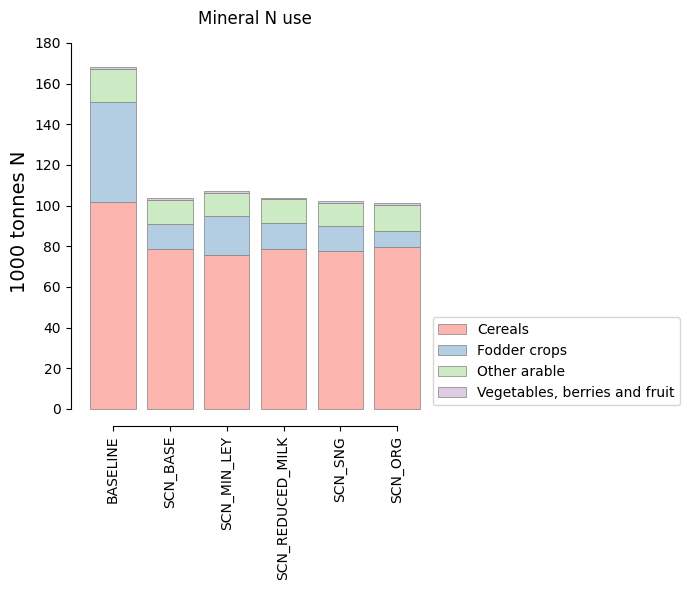

In [21]:
fig, ax = plt.subplots(figsize=(7,6))

plot_data3 = (
    (session.get_attr('C','fertiliser.mineral_N',groupby={'crop':'crop_group2'})/1000000)
    .drop(['Greenhouse crops','Semi-natural grasslands'], axis=1, errors='ignore')
    .droplevel('year')
)

plot.bar(
    data=plot_data3,
    ax=ax,
    cmap='Pastel1',
    edgecolor='grey',
)

ax.set_title('Mineral N use')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 tonnes N', size=14)
ax.set_ylim(top=plot_data3.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

## N and P application

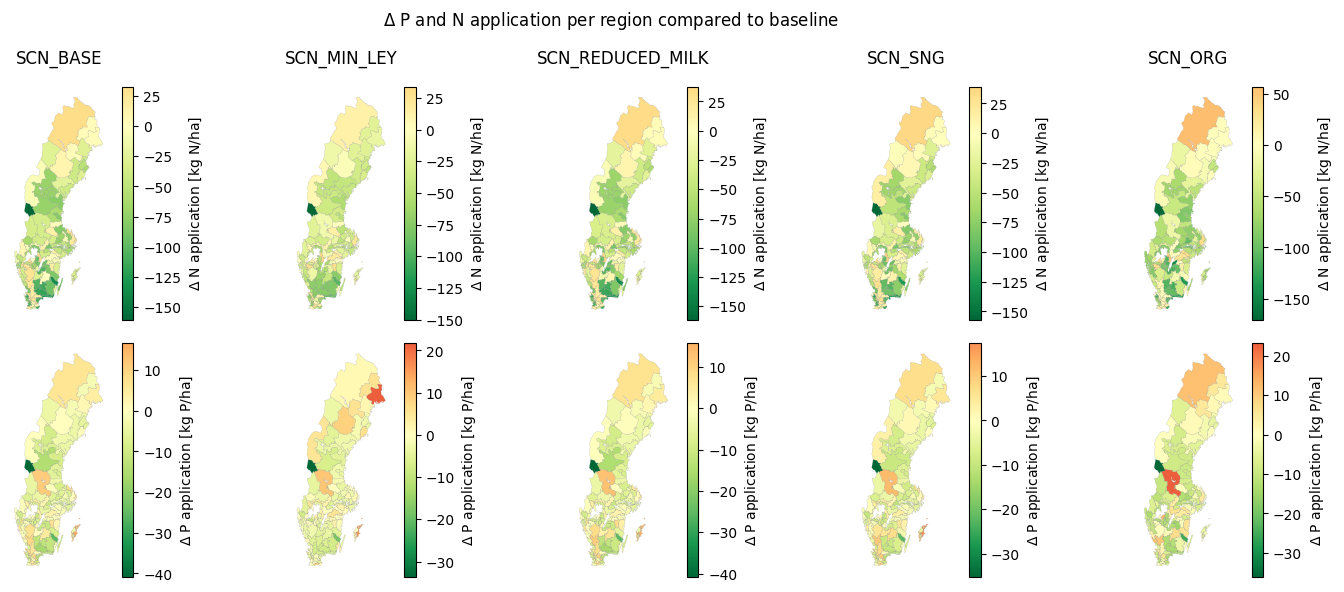

In [22]:
# CHANGES IN N AND P APPLICATION

scenarios = [scn for scn in session.scenarios()][1:]

plot_data_N = (
    (session.get_attr('C','fertiliser.manure_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
).droplevel("year")
plot_data_N = (plot_data_N - plot_data_N.loc['BASELINE'])

plot_data_P = (
    (session.get_attr('C','fertiliser.manure_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
).droplevel("year")
plot_data_P = (plot_data_P - plot_data_P.loc['BASELINE'])

fig, axs2d = plt.subplots(2, len(scenarios), figsize=(3*(len(scenarios)), 6))

styles = { 
    "cmap": "RdYlGn_r",
    "cmap_zero_midpoint": "shrink",
    "edgecolor": "grey"
}

for scn, axs in zip(scenarios, axs2d.T):   
    for map_data, ax, label in [
        (plot_data_N.loc[scn], axs[0], r'$\Delta$ N application [kg N/ha]'),
        (plot_data_P.loc[scn], axs[1], r'$\Delta$ P application [kg P/ha]'),
    ]:
        lim = abs(map_data).quantile(0.99)
        plot.map_from_series(map_data, ax=ax, legend_kwds={'label': label}, **styles)
        ax.axis('off')

    axs[0].set_title(scn)
    
fig.suptitle(r"$\Delta$ P and N application per region compared to baseline")
fig.tight_layout()

## Diversity in crops (**not** overall biodiversity)

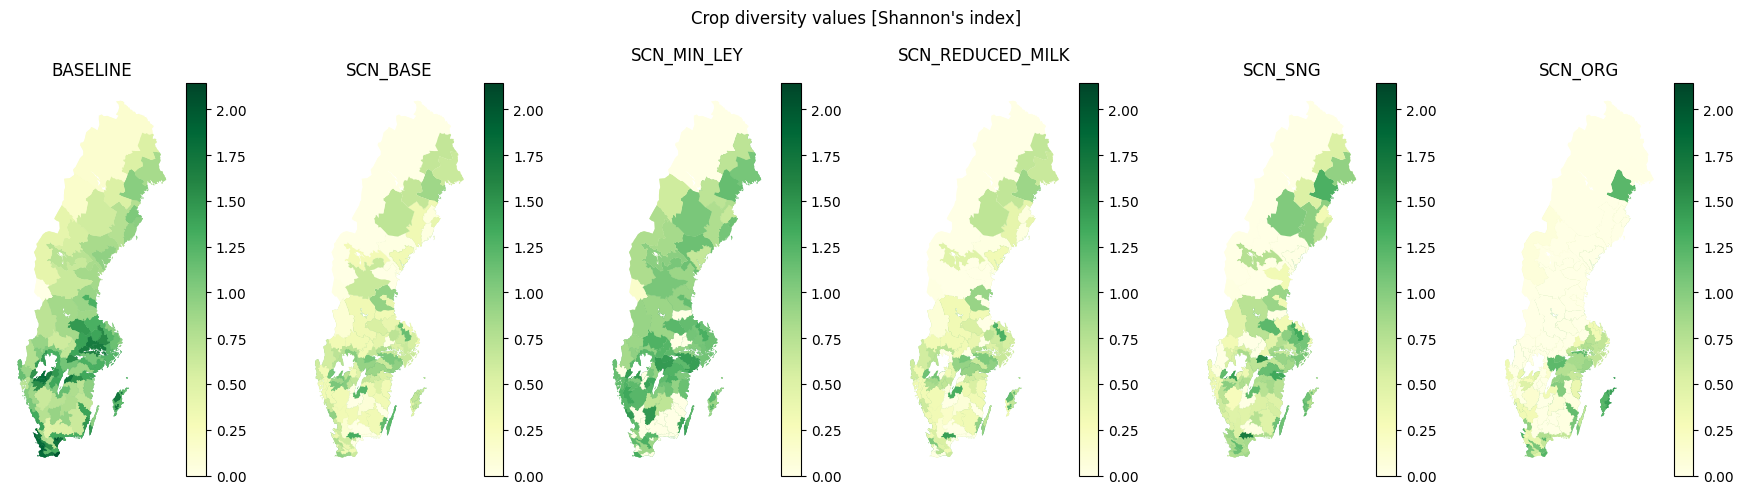

In [23]:
biodiv_data = cm.impact.biodiv.get_crop_div(session).droplevel("year")

fig, axs = plt.subplots(1, len(session.scenarios()), figsize=(18, 5))
vmax=biodiv_data.max().max()

for scn, ax in zip(list(session.scenarios().keys()), axs):
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(biodiv_data.loc[(scn),:], cmap="YlGn", ax=ax, vmin=0, vmax=vmax)#, legend_kwds={"label": "Biodiversity index"})

fig.suptitle("Crop diversity values [Shannon's index]")
fig.tight_layout()

Text(0.5, 0.98, 'Share of organic land-use')

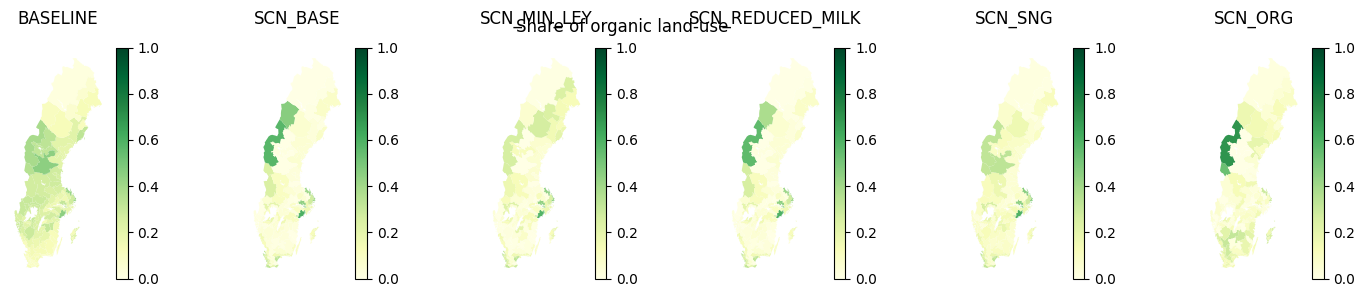

In [24]:
total_prod = session.get_attr("c", "area", ["region"]).droplevel("year")
organic_prod = session.get_attr("c", "area", ["prod_system", "region"]).droplevel("year").loc[:, ("organic", )]
organic_share = (organic_prod / total_prod).replace({ np.inf: 0, -np.inf: 0, np.nan: 0 })

scenarios = [s for s in session.scenarios()]
n_scn = len(scenarios)
fig, axs = plt.subplots(1, len(scenarios), figsize=(n_scn*3, 3))

for scn, ax in zip(scenarios, axs):
    plot.map_from_series(
        organic_share.loc[scn],
        ax=ax,
        vmin=0,
        vmax=1,
        cmap="YlGn"
    )
    ax.set_title(scn)
    ax.set_axis_off()

fig.suptitle("Share of organic land-use")
